In [1]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
param = Parameters()
param.ENV_DC = True
param.MAX_LINE_STATUS_CHANGED = 99999
param.MAX_SUB_CHANGED = 99999
backend=LightSimBackend()
env = grid2op.make("l2rpn_case14_sandbox", param=param,backend=backend)


ModuleNotFoundError: No module named 'networkx.utils'

# compute the A matrix that defines the delta

$$\delta_{i,j} = \frac{F_j^{i} - F_j}{F_i}$$

with:
- $\delta_{i,j}$ : "le coefficient de report"
- $F_k$: the active flow on line `k`
- $F_j^{i}$: the flow on line j if the line i is disconnected

We are interested, given all the $\delta_{i,j}$ to compute the $\delta_{\{i,j,k, ...\}, m}$ which are the flows on line `m` when the lines $\{i,j,k, ...\}$ are disconnected

In [ ]:
_ = env.reset()
#with env.copy() as tmp_env_init:
init_obs, *_ = env.simulate(env.action_space())
F = 1. * init_obs.p_or

In [ ]:
init_obs

In [ ]:
all_flows = np.zeros((env.n_line, env.n_line))
for l_id in range(env.n_line):
    #with env.copy() as tmp_env:
    obs, *_ = env.simulate(env.action_space({"set_line_status": [(l_id, -1)]}))
    all_flows[l_id, :] = obs.p_or

In [ ]:
A = (all_flows - F) / F.reshape(-1, 1)

In [ ]:
F

In [ ]:
A[3][3]

In [ ]:
init_obs.p_or[2] + A[1, 2] * init_obs.p_or[1]

In [ ]:
all_flows[1, 2]

In [ ]:
all_flows[1]

In [ ]:
env.name_line

<ipython-input-12-8be531440444>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


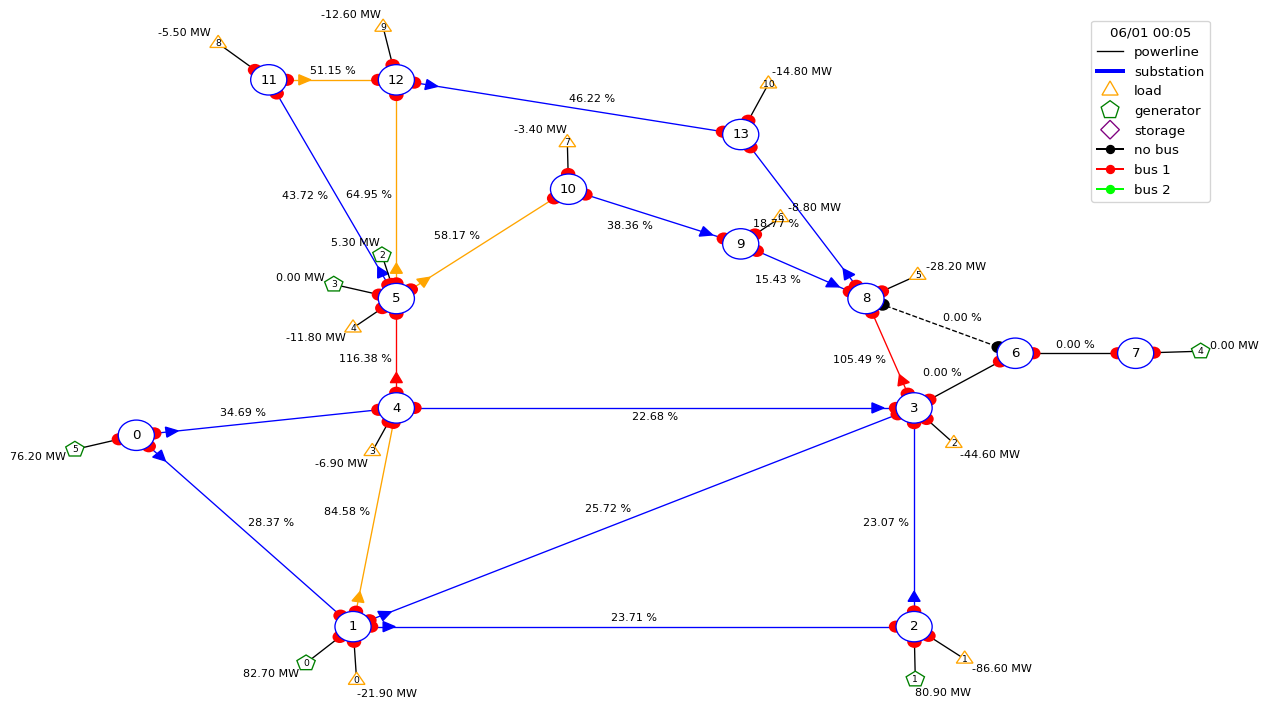

In [12]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs)
fig.show()


In [13]:
id_l1=3
id_l2=7
#with env.copy() as tmp_env:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

In [14]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

In [15]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

<ipython-input-16-395f7dd74f78>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


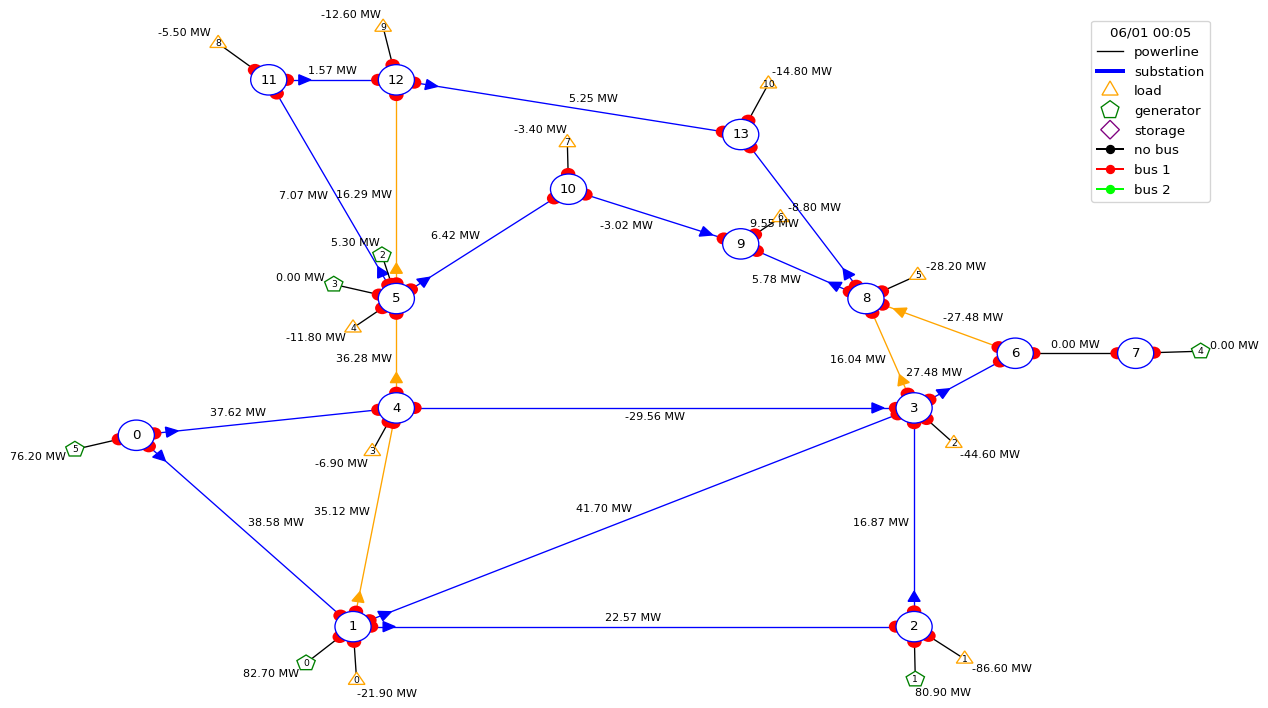

In [16]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(init_obs,line_info='p')
fig.show()

<ipython-input-17-49110e397e6e>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


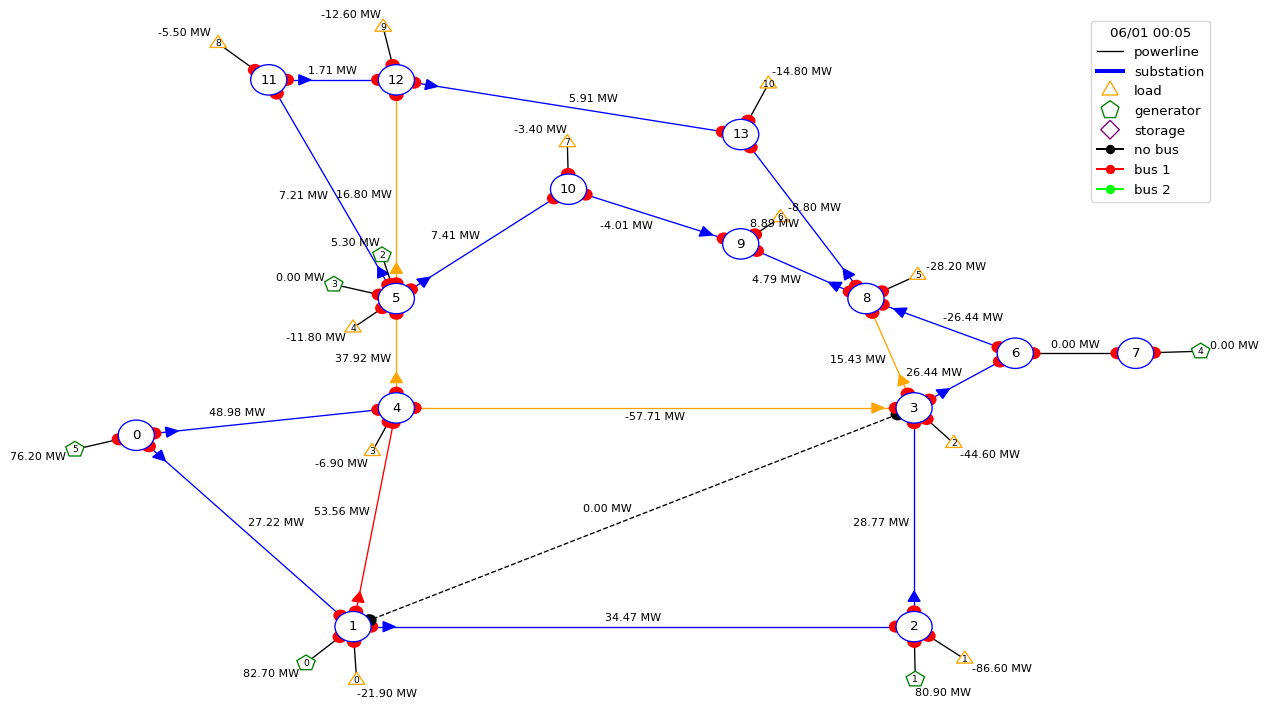

In [17]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnect_l1,line_info='p')
fig.show()

<ipython-input-18-f281e793134a>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


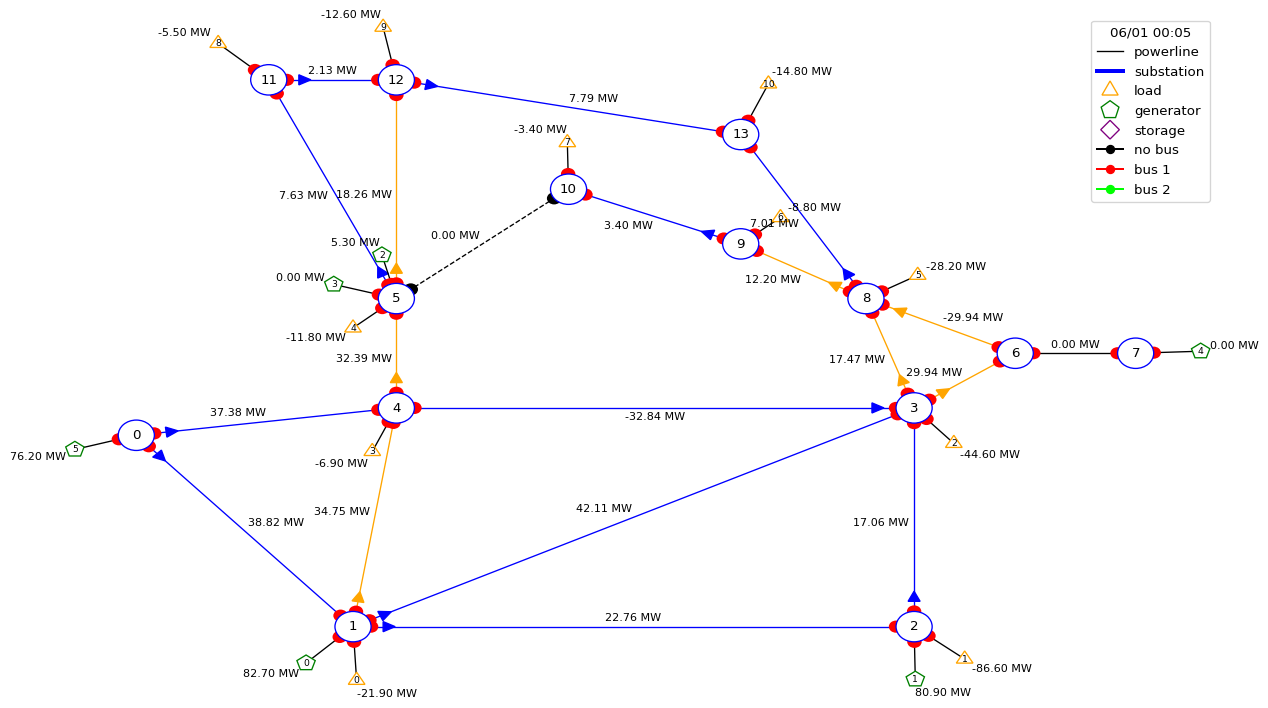

In [18]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnect_l2,line_info='p')
fig.show()

<ipython-input-19-0a414854a312>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


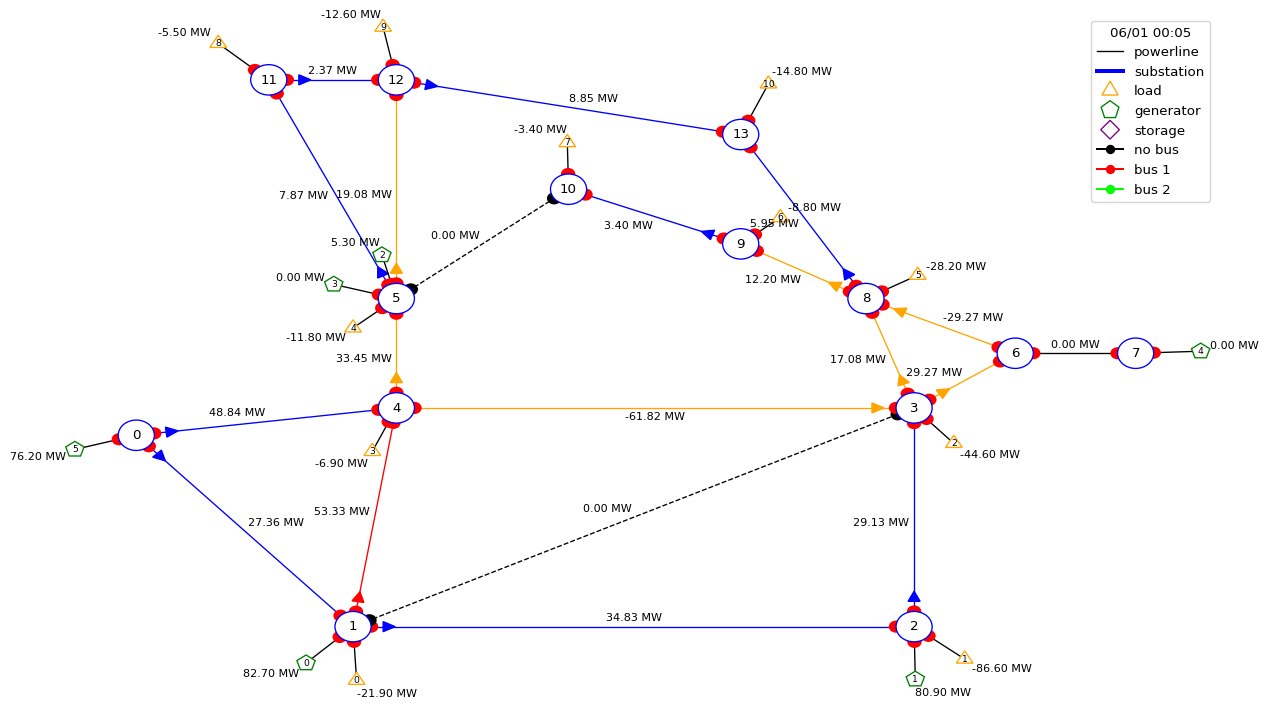

In [19]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info='p')
fig.show()

In [20]:
init_obs, *_ = env.simulate(env.action_space())
delta_P_l1_disconnected=obs_disconnect_l1.p_or.copy()-init_obs.p_or.copy()
delta_P_l2_disconnected=obs_disconnect_l2.p_or.copy()-init_obs.p_or.copy()
delta_P_l1_connected=obs_disconnect_l1.p_or.copy()-obs_disconnected_l1_l2.p_or.copy()
delta_P_l2_connected=obs_disconnect_l2.p_or.copy()-obs_disconnected_l1_l2.p_or.copy()

In [21]:
print(delta_P_l2_disconnected/delta_P_l1_disconnected)
print(delta_P_l1_connected/delta_P_l2_connected)

[-0.02042435 -0.02042435  0.01653502 -0.00987613 -0.02042418  0.01653502
  0.1164894  -6.4752555   3.8672056   3.8672092  -6.475255    3.8672013
 -6.4752555   3.867204    3.8672042  -2.360781   -2.3607805  -2.3607843
         nan -2.360781  ]
[-0.01209631 -0.01209631  0.03011468  0.         -0.0120963   0.03011483
  0.14190121         inf  2.774848    2.774847          -inf  2.7748454
        -inf  2.7748451   2.7748458  -4.2294097  -4.2294116  -4.2293944
         nan -4.2294097 ]


<ipython-input-21-2b208f3edcda>:1: RuntimeWarning: invalid value encountered in true_divide
  print(delta_P_l2_disconnected/delta_P_l1_disconnected)
<ipython-input-21-2b208f3edcda>:2: RuntimeWarning: divide by zero encountered in true_divide
  print(delta_P_l1_connected/delta_P_l2_connected)
<ipython-input-21-2b208f3edcda>:2: RuntimeWarning: invalid value encountered in true_divide
  print(delta_P_l1_connected/delta_P_l2_connected)


In [22]:
#a generic version for n-K
def get_Virtual_Flows_NPlusK(por_init,A,ilds):
    a=[]
    for idl in ilds:
        a_row=np.array([A[idlj][idl] if idl==idlj else -A[idlj][idl] for idlj in ilds])
        a.append(a_row)

    b=np.array([-p for p in por_init])
    pls_virtual=np.linalg.solve(a,b)
    print(pls_virtual)
    
    return pls_virtual

In [23]:
id_l3=0
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))



<ipython-input-24-c36d16a0a585>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


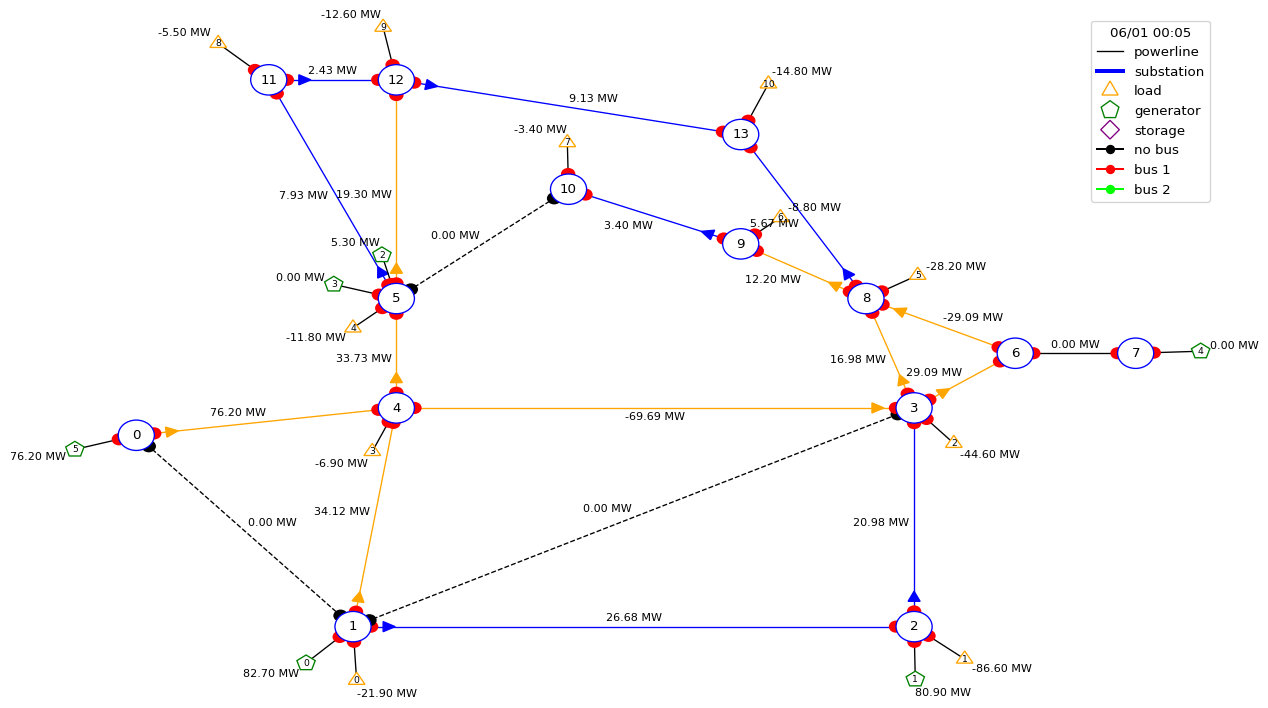

In [24]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l1_l2_l3,line_info='p')
fig.show()

<ipython-input-25-5f085b86579c>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


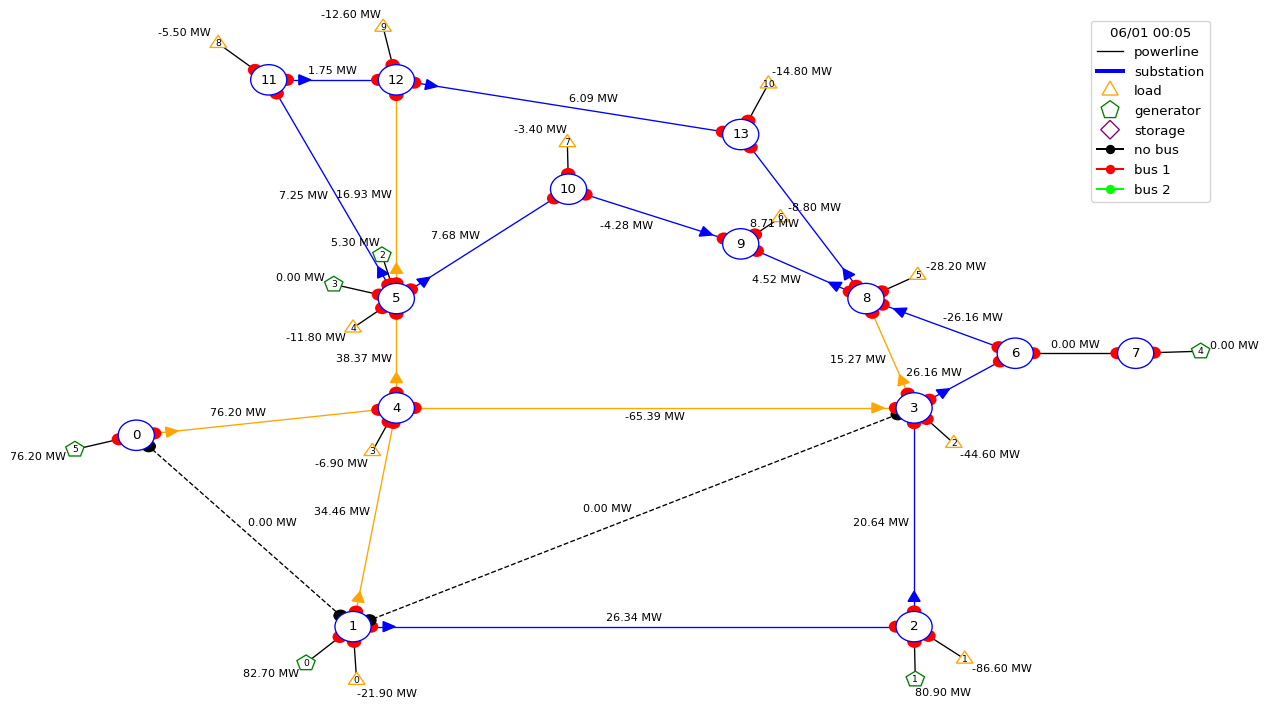

In [25]:
obs_disconnected_l1_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l1_l3,line_info='p')
fig.show()

<ipython-input-26-1840ad477361>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


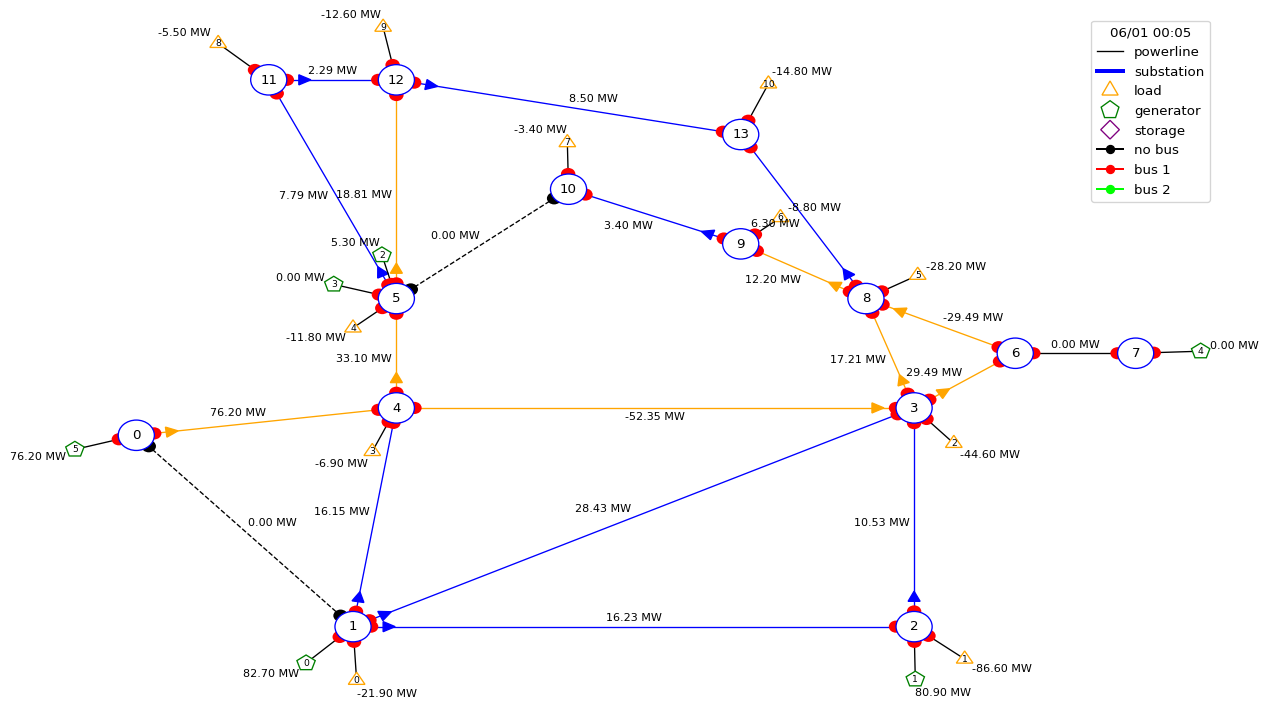

In [26]:
obs_disconnected_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))

plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_disconnected_l2_l3,line_info='p')
fig.show()

In [27]:
init_obs, *_ = env.simulate(env.action_space())
por_end=init_obs.p_or.copy()

obs_disconnected_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))
por_l1_connected=obs_disconnected_l2_l3.p_or.copy()

obs_disconnected_l1_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))
por_l2_connected=obs_disconnected_l1_l3.p_or.copy()

obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
por_l3_connected=obs_disconnected_l1_l2.p_or.copy()

obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
por_l1_l2_l3=obs_disconnected_l1_l2_l3.p_or.copy()

p_init=[por_l1_connected,por_l2_connected,por_l3_connected,por_l1_l2_l3]
alpha=[]

pl1_init=por_l1_connected[id_l1]
pl1_end=por_end[id_l1]
alpha.append(pl1_end/pl1_init)
print(pl1_init)
print(pl1_end)

pl2_init=por_l2_connected[id_l2]
pl2_end=por_end[id_l2]
alpha.append(pl2_end/pl2_init)
print(pl2_init)
print(pl2_end)

pl3_init=por_l3_connected[id_l3]
pl3_end=por_end[id_l3]
alpha.append(pl3_end/pl3_init)
print(pl3_init)
print(pl3_end)

(por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]+alpha[2]*p_init[2]))/por_l1_l2_l3


28.426771
41.696144
7.6831803
6.4211507
27.362656
38.58359


<ipython-input-27-24997438aa24>:37: RuntimeWarning: invalid value encountered in true_divide
  (por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]+alpha[2]*p_init[2]))/por_l1_l2_l3


array([       nan, -2.7126148, -2.7126148,        nan, -2.7126148,
       -2.7126148, -2.7126148,        nan, -2.7126148, -2.712615 ,
       -2.7126148, -2.7126145, -2.7126148, -2.712615 , -2.7126145,
       -2.7126145, -2.7126145, -2.7126148,        nan, -2.7126145],
      dtype=float32)

In [28]:
1-np.sum(alpha)

-2.7126147747039795

In [29]:
por_Ldisconnected=[obs_disconnected_l2_l3.p_or[id_l1],obs_disconnected_l1_l3.p_or[id_l2],obs_disconnected_l1_l2.p_or[id_l3]]

por_Ldisconnected



[28.426771, 7.6831803, 27.362656]

In [30]:
#compute virtual flows for disconnections

In [120]:
YBus=env.backend._grid.get_dcYbus().todense()

In [121]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2,id_l3])
p_end

[31.48895452  7.69634534 30.28299473]


array([ 4.8924323e-07,  7.6199997e+01,  2.6675289e+01, -3.9898677e-07,
        3.4124710e+01,  2.0975294e+01, -6.9691467e+01, -5.6055299e-08,
        7.9306002e+00,  1.9302643e+01,  1.2200000e+01,  5.6667576e+00,
        3.4000001e+00,  2.4306002e+00,  9.1332417e+00,  2.9089725e+01,
        1.6977028e+01,  3.3733246e+01,  0.0000000e+00, -2.9089725e+01],
      dtype=float32)

In [125]:
init_obs.p_or[id_l1]

41.696144

In [124]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

theta_or=obs_disconnect_l1.theta_or
theta_ex=obs_disconnect_l1.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l1.v_or
v_ex=obs_disconnect_l1.v_or

sub_l1_ex=obs_disconnect_l1.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnect_l1.line_or_to_subid[id_l1]

delta_theta_l1=-0.9229497+7.7327113#theta_or[id_l1]-theta_ex[id_l1]
print(delta_theta_l1)


virtual_flow_l1=YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159)

print(virtual_flow_l1)

[  0.          0.         -0.9229497   0.         -0.9229497  -4.8323455
  -7.651187  -11.362224  -11.362224  -11.362224  -12.416822  -12.416822
 -12.648595  -12.419546  -12.615822   -7.651187   -7.651187   -6.258751
 -10.74999   -12.416822 ]
[ -0.9229497  -6.258751   -4.8323455   0.         -6.258751   -7.651187
  -6.258751  -12.206995  -12.419546  -12.615822  -12.648595  -13.794139
 -12.206995  -12.615822  -13.794139  -10.74999   -12.416822  -11.362224
 -10.74999   -10.74999  ]
6.8097616
(-67.40736207193989+0j)


In [141]:
pinv_Bbus=np.linalg.pinv(YBus)
n_nodes=pinv_Bbus.shape[0]
R_eq=np.array([[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

In [144]:
R_eq[sub_l1_or][sub_l1_ex]

(0.0659323689293208+0j)

In [147]:
1/YBus[sub_l1_or,sub_l1_ex]

(-0.17632-0j)

In [151]:
1/(1/R_eq[sub_l1_or][sub_l1_ex]-1/0.176)

(0.10542697084221765+0j)

In [153]:
(0.0659/0.105)*67.407

42.30591714285714

In [149]:
R_eq[sub_l2_or][sub_l2_ex]

(0.1468069814688445+0j)

In [150]:
1/YBus[sub_l2_or,sub_l2_ex]

(-0.1989-0j)

In [128]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

theta_or=obs_disconnect_l2.theta_or
theta_ex=obs_disconnect_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnect_l2.v_or
v_ex=obs_disconnect_l2.v_or

sub_l2_ex=obs_disconnect_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnect_l2.line_or_to_subid[id_l2]

delta_theta_l2=-9.136107+11.930102#theta_or[id_l1]-theta_ex[id_l1]
print(delta_theta_l2)


virtual_flow_l2=YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159)

print(virtual_flow_l2)

[  0.          0.         -1.3159231  -1.3159231  -1.3159231  -3.8978322
  -5.5698323   0.         -9.136107   -9.136107  -10.965277  -10.965277
 -11.555939  -10.254637  -10.498736   -5.5698323  -5.5698323  -4.7774463
  -9.078162  -10.965277 ]
[ -1.3159231  -4.7774463  -3.8978322  -5.5698323  -4.7774463  -5.5698323
  -4.7774463   0.        -10.254637  -10.498736  -11.555939  -12.051602
 -11.930102  -10.498736  -12.051602   -9.078162  -10.965277   -9.136107
  -9.078162   -9.078162 ]
2.793994999999999
(-24.517029082313826+0j)


In [65]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()

p_init_l1=por_init[ids_l[0]]+np.sum([por_init[idlj]*A[idlj][ids_l[0]] for idlj in ids_l if idlj!=ids_l[0]])
p_init_l2=por_init[ids_l[1]]+np.sum([por_init[idlj]*A[idlj][ids_l[1]] for idlj in ids_l if idlj!=ids_l[1]])
(p_end-por_init)/(p_init_l1*A[ids_l[0]]+p_init_l2*A[ids_l[1]])


[42.17226227  7.42411841]


<ipython-input-65-159035e3ca82>:11: RuntimeWarning: invalid value encountered in true_divide
  (p_end-por_init)/(p_init_l1*A[ids_l[0]]+p_init_l2*A[ids_l[1]])


array([1.00152752, 1.00152752, 1.00152736, 1.00152754, 1.00152755,
       1.00152752, 1.00152746, 1.00152754, 1.00152793, 1.00152776,
       1.00152755, 1.00152757, 1.00152754, 1.00152767, 1.00152757,
       1.00152836, 1.00152861, 1.0015279 ,        nan, 1.00152836])

In [66]:


obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnected_l1_l2.p_or

array([ 27.362656 ,  48.837345 ,  34.82913  ,   0.       ,  53.333523 ,
        29.129133 , -61.82488  ,   0.       ,   7.8667383,  19.079252 ,
        12.2      ,   5.954011 ,   3.4      ,   2.3667386,   8.845989 ,
        29.27112  ,  17.082891 ,  33.44599  ,   0.       , -29.27112  ],
      dtype=float32)

In [117]:
theta_or=obs_disconnected_l1_l2.theta_or
theta_ex=obs_disconnected_l1_l2.theta_ex
print(theta_or)
print(theta_ex)

v_or=obs_disconnected_l1_l2.v_or
v_ex=obs_disconnected_l1_l2.v_or

sub_l1_ex=obs_disconnected_l1_l2.line_ex_to_subid[id_l1]
sub_l1_or=obs_disconnected_l1_l2.line_or_to_subid[id_l1]
lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=obs_disconnected_l1_l2.line_ex_to_subid[id_l2]
sub_l2_or=obs_disconnected_l1_l2.line_or_to_subid[id_l2]
lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])


delta_theta_l1=-0.92764634+7.7327113#theta_or[id_l1]-theta_ex[id_l1]
delta_theta_l2=-10.742136+13.972545#theta_or[id_l2]-theta_ex[id_l2]
print(delta_theta_l1)
print(delta_theta_l2)


virtual_flow_l1=YBus[sub_l1_or,sub_l1_ex]*100*(delta_theta_l1/360*2*3.14159)
virtual_flow_l2=YBus[sub_l2_or,sub_l2_ex]*100*(delta_theta_l2/360*2*3.14159)

print(virtual_flow_l1)
print(virtual_flow_l2)


[  0.           0.          -0.92764634   0.          -0.92764634
  -4.8782606   -7.7327113    0.         -10.742136   -10.742136
 -13.00772    -13.00772    -13.598382   -11.89515    -12.166196
  -7.7327113   -7.7327113   -6.2410464  -11.162729   -13.00772   ]
[ -0.92764634  -6.2410464   -4.8782606    0.          -6.2410464
  -7.7327113   -6.2410464    0.         -11.89515    -12.166196
 -13.598382   -13.930093   -13.972545   -12.166196   -13.930093
 -11.162729   -13.00772    -10.742136   -11.162729   -11.162729  ]
6.80506496
2.8562460000000005
(-67.3608717347449+0j)
(-25.06327543472432+0j)


In [130]:
delta_virtual_flow_l2=-25.06327543472432+24.517029082313826
print(delta_virtual_flow_l2)
delta_virtual_flow_l1=-67.3608717347449+67.40736207193989
print(delta_virtual_flow_l1)

-0.5462463524104955
0.046490337194981635


In [131]:
print(A[id_l2][id_l1])
print(A[id_l1][id_l2])

0.06413127335999826
0.023782639948752075


In [132]:
A[id_l2][id_l1]*7

0.4489189135199878

In [135]:
init_obs.p_or[id_l1]

41.696144

In [136]:
42.17226227-init_obs.p_or[id_l1]

0.47611816599609114

In [138]:
init_obs.p_or[id_l2]

6.4211507

In [137]:
7.42411841-init_obs.p_or[id_l2]

1.0029677256433107

In [112]:
theta_or[lines_sub_or_l2]

array([  0.       , -10.742136 , -10.742136 ,  -6.2410464], dtype=float32)

In [116]:
theta_or=init_obs.theta_or
theta_ex=init_obs.theta_ex
print(theta_or)
print(theta_ex)

v_or=init_obs.v_or
v_ex=init_obs.v_or

sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
sub_l1_or=init_obs.line_or_to_subid[id_l1]
#lines_sub_or_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_or)['lines_ex_id'])
#lines_sub_ex_l1=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l1_ex)['lines_ex_id'])

sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
sub_l2_or=init_obs.line_or_to_subid[id_l2]
#lines_sub_or_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_or)['lines_ex_id'])
#lines_sub_ex_l2=list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_or_id'])+list(obs_disconnected_l1_l2.get_obj_connect_to(substation_id=sub_l2_ex)['lines_ex_id'])

init_obs.v_or[sub_l1_or]
v_or_l1=init_obs.v_or[id_l1]#138##np.max(v_or[lines_sub_or_l1])
v_ex_l1=init_obs.v_ex[id_l1]#138#np.max(v_or[lines_sub_ex_l1])
v_or_l2=init_obs.v_or[id_l2]#22#np.max(v_or[lines_sub_or_l2])
v_ex_l2=init_obs.v_ex[id_l2]#np.max(v_or[lines_sub_ex_l2])


delta_theta_l1=theta_or[id_l1]-theta_ex[id_l1]
delta_theta_l2=theta_or[id_l2]-theta_ex[id_l2]
print(delta_theta_l1)
print(delta_theta_l2)

virtual_flow_l1=YBus[sub_l1_or,sub_l1_ex]*delta_theta_l1/360*2*3.14159*100
virtual_flow_l2=YBus[sub_l2_or,sub_l2_ex]*delta_theta_l2/360*2*3.14159*100
print(virtual_flow_l1)
print(virtual_flow_l2)



[  0.          0.         -1.3080575  -1.3080575  -1.3080575  -3.8676474
  -5.5203657  -9.68895    -9.68895    -9.68895   -10.473401  -10.473401
 -10.753183  -10.724925  -10.904521   -5.5203657  -5.5203657  -4.807095
  -8.741024  -10.473401 ]
[ -1.3080575  -4.807095   -3.8676474  -5.5203657  -4.807095   -5.5203657
  -4.807095  -10.420712  -10.724925  -10.904521  -10.753183  -11.952206
 -10.420712  -10.904521  -11.952206   -8.741024  -10.473401   -9.68895
  -8.741024   -8.741024 ]
4.212308
0.7317629
(-41.6961095665258+0j)
(-6.4211467660397075+0j)
0.429349087351787
0.07458660014983554


In [99]:
v_ex_l1

138.0

In [105]:
init_obs.p_or[id_l2]

6.4211507

In [93]:
env2 = grid2op.make("l2rpn_case14_sandbox", param=param)
impedences=env2.backend._grid.line['x_ohm_per_km']

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [94]:
1/impedences[id_l1]

0.02978106675114007

In [81]:
env.backend._grid.get_lineex_theta()

array([ -1.35851373,  -4.84692784,  -3.95738047,  -5.56563593,
        -4.84692784,  -5.56563593,  -4.84692784, -10.46882525,
       -10.74995555, -10.93157324, -10.80092743, -11.95593844,
       -10.46882525, -10.93157324, -11.95593844])

In [ ]:
env.backend

In [85]:
init_obs, *_ = env.simulate(env.action_space())
init_obs.theta_or

array([  0.       ,   0.       ,  -1.3080575,  -1.3080575,  -1.3080575,
        -3.8676474,  -5.5203657,  -9.68895  ,  -9.68895  ,  -9.68895  ,
       -10.473401 , -10.473401 , -10.753183 , -10.724925 , -10.904521 ,
        -5.5203657,  -5.5203657,  -4.807095 ,  -8.741024 , -10.473401 ],
      dtype=float32)

In [64]:
YBus[sub_l1_or,sub_l1_ex]

(-5.671506352087114+0j)

In [42]:
YBus[sub_l1_or,sub_l1_ex]

(-5.671506352087114+0j)

In [50]:
lines_sub_or_l1

[2, 3, 4, 0]

In [60]:
print(lines_sub_or_l1)
print(obs_disconnected_l1_l2.theta_or[lines_sub_or_l1])
print(lines_sub_or_l2)
obs_disconnected_l1_l2.theta_or[lines_sub_or_l2]

[2, 3, 4, 0]
[-0.92764634  0.         -0.92764634  0.        ]
[7, 8, 9, 17]


array([  0.       , -10.742136 , -10.742136 ,  -6.2410464], dtype=float32)

In [61]:
print(lines_sub_ex_l1)
print(obs_disconnected_l1_l2.theta_or[lines_sub_ex_l1])
print(lines_sub_ex_l2)
obs_disconnected_l1_l2.theta_or[lines_sub_ex_l2]

[6, 15, 16, 3, 5]
[-7.7327113 -7.7327113 -7.7327113  0.        -4.8782606]
[7, 12]


array([  0.      , -13.598382], dtype=float32)

In [37]:
p_init_l1

28.062288284301758

In [38]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()

p_init_l1=por_init[ids_l[0]]+\
    por_init[ids_l[1]]*(A[ids_l[1]][ids_l[0]]+A[ids_l[1]][ids_l[2]]*A[ids_l[2]][ids_l[0]])+\
    por_init[ids_l[2]]*(A[ids_l[2]][ids_l[0]]+A[ids_l[2]][ids_l[1]]*A[ids_l[1]][ids_l[0]])

p_init_l2=por_init[ids_l[1]]+\
    por_init[ids_l[0]]*(A[ids_l[0]][ids_l[1]]+A[ids_l[0]][ids_l[2]]*A[ids_l[2]][ids_l[1]])+\
    por_init[ids_l[2]]*(A[ids_l[2]][ids_l[1]]+A[ids_l[2]][ids_l[0]]*A[ids_l[0]][ids_l[1]])

p_init_l3=por_init[ids_l[2]]+\
    por_init[ids_l[0]]*(A[ids_l[0]][ids_l[2]]+A[ids_l[0]][ids_l[1]]*A[ids_l[1]][ids_l[2]])+\
    por_init[ids_l[1]]*(A[ids_l[1]][ids_l[2]]+A[ids_l[1]][ids_l[0]]*A[ids_l[0]][ids_l[2]])

p_init=[p_init_l1,p_init_l2,p_init_l3]
print(p_init)

(p_end-por_init)/(p_init_l1*A[ids_l[0]]+p_init_l2*A[ids_l[1]]+p_init_l3*A[ids_l[2]])



[31.48895452  7.69634534 30.28299473]
[28.43510625808842, 7.561688321873499, 27.379769744144298]


<ipython-input-38-ce420093d957>:24: RuntimeWarning: invalid value encountered in true_divide
  (p_end-por_init)/(p_init_l1*A[ids_l[0]]+p_init_l2*A[ids_l[1]]+p_init_l3*A[ids_l[2]])


array([1.1070297 , 1.10702967, 1.10351289, 1.10820166, 1.04697715,
       1.1035132 , 1.09743308, 1.00180539, 1.03590302, 1.03590347,
       1.0018054 , 1.03590341, 1.00180539, 1.0359033 , 1.03590334,
       0.95389189, 0.95389178, 0.9538912 ,        nan, 0.95389189])

In [ ]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()

p_init_l1=por_init[ids_l[0]]+\
    (por_init[ids_l[1]]+A[ids_l[2]][ids_l[1]]*por_init[ids_l[2]])*A[ids_l[1]][ids_l[0]]+\
    (por_init[ids_l[2]]+A[ids_l[1]][ids_l[2]]*por_init[ids_l[1]])*A[ids_l[2]][ids_l[0]]

p_init_l2=por_init[ids_l[1]]+\
    (por_init[ids_l[0]]+A[ids_l[2]][ids_l[0]]*por_init[ids_l[2]])*A[ids_l[0]][ids_l[1]]+\
    (por_init[ids_l[2]]+A[ids_l[0]][ids_l[2]]*por_init[ids_l[0]])*A[ids_l[2]][ids_l[1]]

p_init_l3=por_init[ids_l[2]]+\
    (por_init[ids_l[0]]+A[ids_l[1]][ids_l[0]]*por_init[ids_l[1]])*A[ids_l[0]][ids_l[2]]+\
    (por_init[ids_l[1]]+A[ids_l[0]][ids_l[1]]*por_init[ids_l[0]])*A[ids_l[1]][ids_l[2]]

p_init=[p_init_l1,p_init_l2,p_init_l3]
print(p_init)

(p_end-por_init)/(p_init_l1*A[ids_l[0]]+p_init_l2*A[ids_l[1]]+p_init_l3*A[ids_l[2]])



In [ ]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2,id_l3]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()

def get_Approx_Virtual_Flows_NK(por_init,A,idls,niter):
    pl_virtuals=np.array([por_init[id_l] for id_l in idls])
    
    residuals=np.array([np.sum([por_init[id_lj]*A[id_lj][id_l] for id_lj in idls if id_lj!=id_l] ) for id_l in idls])
    pl_virtuals+=residuals

    
    for i in range(niter):
        residuals=np.array([np.sum([residuals[j]*A[id_lj][id_l] for j,id_lj in enumerate(idls)
                                    if id_lj!=id_l] ) for id_l in idls])
        print(residuals)
        pl_virtuals+=residuals

    return pl_virtuals #[28.426771, 7.6831803, 27.362656]

get_Approx_Virtual_Flows_NK(por_init,A,ids_l,niter=10)



### computing P when connecting lines to fully connected topology

In [43]:
#so pVirtual_l1=por_Lconnected_l1+(DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l1*LODF3->1)
#por_l2=LODF1->2*pVirtual1=LODF1->2*(por_Lconnected_l1+(DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l3*LODF3->1))
#por_l3=LODF1->3*pVirtual1=LODF1->3*(por_Lconnected_l1+(DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l1*LODF3->1))

#(por_l2-LODF3->2*DeltaPVirtual_l3)-DeltaPVirtual_l2=0
#(LODF1->2*(por_Lconnected_l1+(DeltaPVirtual_l2*LODF2->1+DeltaPVirtual_l3*LODF3->1))-LODF3->2*DeltaPVirtual_l3)-DeltaPVirtual_l2=0
#LODF1->2*por_Lconnected_l1+(LODF1->2*LODF2->1-1)*DeltaPVirtual_l2+(LODF1->2*LODF3->1-LODF3->2)*DeltaPVirtual_l3=0

#LODF1->3*por_Lconnected_l1+(LODF1->3*LODF2->1-LODF2->3)*DeltaPVirtual_l2+(LODF1->3*LODF3->1-1)*DeltaPVirtual_l3=0

#a generic version for n-K
def get_DeltaVirtual_Flows_NK(il_connect,p_il_connect,A,ilds):
    
    
    a=[]
    for idl in ilds:
        a_row=np.array([A[il_connect][idl]*A[idlj][il_connect]+A[idlj][idl] for idlj in ilds])
        a.append(a_row)

    b=np.array([-p_il_connect*A[il_connect][idl] for idl in ilds])
    pls_virtual=np.linalg.solve(a,b)
    print(pls_virtual)
    
    por_virtual_il_connect=p_il_connect
    for i in range(len(ilds)):
        por_virtual_il_connect+=A[ilds[i]][il_connect]*pls_virtual[i]
    
    return por_virtual_il_connect




In [104]:
init_obs, *_ = env.simulate(env.action_space())
por_end=init_obs.p_or.copy()

obs_disconnected_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
por_l1_connected=obs_disconnected_l2.p_or.copy()

obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
por_l2_connected=obs_disconnected_l1.p_or.copy()

obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
por_l1_l2=obs_disconnected_l1_l2.p_or.copy()

p_init=[por_l1_connected,por_l2_connected,por_l1_l2]
alpha=[]

pl1_init=por_l1_connected[id_l1]
pl1_end=por_end[id_l1]
alpha.append(pl1_end/pl1_init)
print(pl1_init)
print(pl1_end)

pl2_init=por_l2_connected[id_l2]
pl2_end=por_end[id_l2]
alpha.append(pl2_end/pl2_init)
print(pl2_init)
print(pl2_end)

print(alpha)

(por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]))/por_l1_l2


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



42.10794
41.696144
7.412795
6.4211507
[0.9902204, 0.8662253]


<ipython-input-104-ed78bb1a4a7f>:30: RuntimeWarning: divide by zero encountered in true_divide
  (por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]))/por_l1_l2
<ipython-input-104-ed78bb1a4a7f>:30: RuntimeWarning: invalid value encountered in true_divide
  (por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]))/por_l1_l2


array([-0.85644567, -0.8564458 , -0.8564457 ,         nan, -0.8564457 ,
       -0.8564457 , -0.85644585,         nan, -0.8564457 , -0.85644567,
       -0.85644585, -0.85644567, -0.8564457 , -0.85644567, -0.8564457 ,
       -0.8564457 , -0.8564457 , -0.8564457 ,         inf, -0.8564457 ],
      dtype=float32)

In [60]:
print(alpha)

[1.4667914, 0.8357412, 1.4100821]


In [47]:
#p_end=(1-sum(alphas))*P_init+sum(alpha_i*p_connect_li)
#alpha_i=p_end_i/p_connect_li_i
#p_end=(1-sum(p_end_i/p_connect_li_i))*P_init+sum(p_end_i/p_connect_li_i*p_connect_li)
#p_end(1+())
#[1..0..(p_init-p_connect_li)[0]/p_connect_li_i...0
# 0 1 ..0..(p_init-p_connect_li)[1]/p_connect_li_i...0    *p_end=P_init
# 0 0 1 ..0..(p_init-p_connect_li[2])/p_connect_li_i...0]
import cvxpy as cp
p_init=por_l1_l2_l3
ilds=[id_l1,id_l2,id_l3]
p_ilds_connect=[por_l1_connected,por_l2_connected,por_l3_connected]
def get_Flows_NPlusK_no_LODF(p_init,ilds,p_ilds_connect):
    
    n_lines=len(p_init)
    n_disconnect=len(ilds)
    p_end = cp.Variable(n_lines)
    alphas = cp.Variable(n_disconnect)
    
    objective = cp.Minimize(cp.sum_squares(p_end-(1-sum(alphas)*p_init)
                                           -sum(alphas*p_ilds_connect)))#[i]*p_ilds_connect[i] for i in range(n_disconnect))))
    constraints = []# [0 <= x, x <= 1]
    for i,idl in enumerate(ilds):
        constraints.append(alphas[i] == p_end[idl]/p_ilds_connect[i][idl])
    
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve()
    print(alphas.value)
    print(p_end.value)
        
    
    

In [ ]:
init_obs, *_ = env.simulate(env.action_space())
por_end=init_obs.p_or.copy()

obs_disconnected_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))
por_l1_connected=obs_disconnected_l2_l3.p_or.copy()

obs_disconnected_l1_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))
por_l2_connected=obs_disconnected_l1_l3.p_or.copy()

obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
por_l3_connected=obs_disconnected_l1_l2.p_or.copy()

obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
por_l1_l2_l3=obs_disconnected_l1_l2_l3.p_or.copy()

p_init=[por_l1_connected,por_l2_connected,por_l3_connected,por_l1_l2_l3]
alpha=[]

pl1_init=por_l1_connected[id_l1]
pl1_end=por_end[id_l1]
alpha.append(pl1_end/pl1_init)
print(pl1_init)
print(pl1_end)

pl2_init=por_l2_connected[id_l2]
pl2_end=por_end[id_l2]
alpha.append(pl2_end/pl2_init)
print(pl2_init)
print(pl2_end)

pl3_init=por_l3_connected[id_l3]
pl3_end=por_end[id_l3]
alpha.append(pl3_end/pl3_init)
print(pl3_init)
print(pl3_end)

(por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]+alpha[2]*p_init[2]))/por_l1_l2_l3


In [115]:
ilds=[id_l1,id_l2,id_l3]
p_init=por_l1_l2_l3
p_ilds_connect=[por_l1_connected,por_l2_connected,por_l3_connected]
p_ilds_connect=np.array(p_ilds_connect)

n_lines=len(p_init)
n_disconnect=len(ilds)
p_end = cp.Variable(n_lines)
alphas = cp.Variable(n_disconnect)

objective = cp.Minimize(cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -alphas*p_ilds_connect))#[i]*p_ilds_connect[i] for i in range(n_disconnect))))


constraints = []# [0 <= x, x <= 1]
for i,idl in enumerate(ilds):
    constraints.append(alphas[i] == p_end[idl]/p_ilds_connect[i][idl])

constraints.append(sum(alphas)>= 1)
constraints.append(alphas >= 0.5)

prob = cp.Problem(objective, constraints)

result = prob.solve()
print(alphas.value)
print(p_end.value)



[0.49993348 0.49991475 0.87045231]
[ 2.38178893e+01  1.93671607e+01  3.57112173e+01  2.10511695e+01
  6.08704532e+01  3.00112220e+01 -3.84330397e+01  3.70576557e+00
  7.36714575e+00  1.73316561e+01  8.49423496e+00  8.20119914e+00
 -3.05765474e-01  1.86714607e+00  6.59880039e+00  2.83500728e+01
  1.65453602e+01  3.49045693e+01 -1.11003372e-14 -2.83500728e+01]


/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 21 times so far.

  warnings.warn(msg, UserWarning)


In [132]:
init_obs, *_ = env.simulate(env.action_space())
por_end=init_obs.p_or.copy()

obs_disconnected_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
por_l1_connected=obs_disconnected_l2.p_or.copy()

obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
por_l2_connected=obs_disconnected_l1.p_or.copy()

obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
por_l1_l2=obs_disconnected_l1_l2.p_or.copy()

p_init=[por_l1_connected,por_l2_connected,por_l1_l2]
alpha=[]

pl1_init=por_l1_connected[id_l1]
pl1_end=por_end[id_l1]
alpha.append(pl1_end/pl1_init)
print(pl1_init)
print(pl1_end)

pl2_init=por_l2_connected[id_l2]
pl2_end=por_end[id_l2]
alpha.append(pl2_end/pl2_init)
print(pl2_init)
print(pl2_end)

print(alpha)

(por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]))/por_l1_l2


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



42.10794
41.696144
7.412795
6.4211507
[0.9902204, 0.8662253]


<ipython-input-132-ed78bb1a4a7f>:30: RuntimeWarning: divide by zero encountered in true_divide
  (por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]))/por_l1_l2
<ipython-input-132-ed78bb1a4a7f>:30: RuntimeWarning: invalid value encountered in true_divide
  (por_end-(alpha[0]*p_init[0]+alpha[1]*p_init[1]))/por_l1_l2


array([-0.85644567, -0.8564458 , -0.8564457 ,         nan, -0.8564457 ,
       -0.8564457 , -0.85644585,         nan, -0.8564457 , -0.85644567,
       -0.85644585, -0.85644567, -0.8564457 , -0.85644567, -0.8564457 ,
       -0.8564457 , -0.8564457 , -0.8564457 ,         inf, -0.8564457 ],
      dtype=float32)

In [167]:
print(init_obs.line_or_bus)
print(init_obs.line_or_to_subid)
init_obs.n_sub

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


14

In [219]:
n_lines=len(p_init)
n_sub=init_obs.n_sub
A_flows=np.zeros((n_sub*2,n_lines))

node_ors=init_obs.line_or_to_subid+n_sub*(init_obs.line_or_bus-1)
node_exs=init_obs.line_ex_to_subid+n_sub*(init_obs.line_ex_bus-1)
for il,node_or in enumerate(node_ors):
    A_flows[node_or][il]=1
    A_flows[node_exs[il]][il]=-1
    
SBus=np.matmul(A_flows,por_end.reshape((n_lines,1))).reshape((28,))
    

In [ ]:
#p_end=(1-sum(alphas))*P_init+sum(alpha_i*p_connect_li)
#alpha_i=p_end_i/p_connect_li_i
#p_end=(1-sum(p_end_i/p_connect_li_i))*P_init+sum(p_end_i/p_connect_li_i*p_connect_li)

#A_flows[i]*((1-sum(alphas)*p_init)+alphas*p_ilds_connect)=0
#A_flows[i]*((1-[1..1][alpha_1   )*p_init + p_ilds_connect*[alpha_1  )=0
#                       ..                                    ..
#                      alpha_n]                             alpha_n]  

#A_flows[i]*([1..1][alpha_1   )*p_init - p_ilds_connect*[alpha_1  )=A_flows[i]*p_init
#                     ..                                    ..
#                   alpha_n]                             alpha_n]  

#A_flows[i]*([1..1][alpha_1   )*p_init - p_ilds_connect*[alpha_1  )=A_flows[i]*p_init
#                     ..                                    ..
#                   alpha_n]                             alpha_n]  

#A_flows[i]*([p ...P     [alpha_1    - p_ilds_connect*[alpha_1  )=A_flows[i]*p_init=Sbus[i]
#             i .. i      ..                              ..
#             nit..nit]   alpha_n]                      alpha_n]  

#A_flows[i]*delta_p_ilds_connect*alpha=Sbus[i]

delta_p_ilds_connect=[]

In [220]:
SBus.reshape((28,)).shape

(28,)

In [ ]:
alphas = [0.9902204, 0.8662253]#cp.Variable(n_disconnect)#np.array([0.9902204, 0.8662253]).reshape((1,2))#cp.Variable(n_disconnect)
#alphas.value=[0.9902204, 0.8662253]


objective = cp.Minimize(cp.sum_squares(p_end-(1-sum(alphas))*p_init -alphas[0]*p_ilds_connect[0]
                                       -alphas[1]*p_ilds_connect[1]))


In [252]:
ilds=[id_l1,id_l2]
p_init=por_l1_l2
p_ilds_connect=[por_l1_connected,por_l2_connected]

delta_p_ilds_connect=p_ilds_connect-p_init

np.matmul(A_flows[0:2],delta_p_ilds_connect.transpose())

array([[0.00000000e+00, 0.00000000e+00],
       [1.90734863e-06, 3.81469727e-06]])

In [251]:
delta_p_ilds_connect.transpose().shape

(20, 2)

In [241]:
ilds=[id_l1,id_l2]
p_init=por_l1_l2
p_ilds_connect=[por_l1_connected,por_l2_connected]
p_ilds_connect=np.array(p_ilds_connect)

n_lines=len(p_init)
n_disconnect=len(ilds)
p_end = cp.Variable(n_lines)
alphas = cp.Variable(n_disconnect)#np.array([0.9902204, 0.8662253]).reshape((1,2))#cp.Variable(n_disconnect)


objective = cp.Minimize(cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -alphas*p_ilds_connect))
                        #+cp.sum_squares(p_end-p_init))#[i]*p_ilds_connect[i] for i in range(n_disconnect))))


constraints = [A_flows @ p_end == SBus]# [0 <= x, x <= 1]
#constraints.append(A_flows @ p_end == SBus)
#for i,idl in enumerate(ilds):
#    constraints.append(alphas[i] == p_end[idl]/p_ilds_connect[i][idl])

#constraints.append(sum(alphas)>= 1)
constraints.append(alphas <= 1.0)
constraints.append(alphas >= 0.5)

prob = cp.Problem(objective, constraints)

result = prob.solve()
print(alphas.value)
print(p_end.value)



[0.79921906 0.79945213]
[ 3.64053141e+01  3.97946868e+01  2.48946960e+01  3.36534674e+01
  3.86571463e+01  1.91946990e+01 -3.53732527e+01  5.92617469e+00
  7.15674397e+00  1.65956606e+01  6.27382562e+00  9.14759602e+00
 -2.52617459e+00  1.65674420e+00  5.65240420e+00  2.75455743e+01
  1.60758482e+01  3.61785807e+01 -1.70805278e-13 -2.75455743e+01]


/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 41 times so far.

  warnings.warn(msg, UserWarning)


In [240]:
result

2.410498326106653e-11

In [224]:
np.matmul(A_flows,p_end.value)

array([ 7.62000008e+01,  6.07999954e+01, -5.69999695e+00, -4.45999966e+01,
       -6.89999962e+00, -6.50000143e+00, -7.91528097e-15,  1.14679946e-14,
       -2.82000008e+01, -8.80000019e+00, -3.40000010e+00, -5.49999976e+00,
       -1.26000006e+01, -1.48000002e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [226]:
p_end.value

array([ 3.88810827e+01,  3.73189181e+01,  2.19681159e+01,  4.30740277e+01,
        3.46389345e+01,  1.62681189e+01, -2.63202543e+01,  1.05562411e+01,
        6.69631093e+00,  1.49850452e+01,  1.64375919e+00,  1.12186445e+01,
       -7.15624100e+00,  1.19631117e+00,  3.58135573e+00,  2.59296337e+01,
        1.51327708e+01,  3.87375986e+01, -1.14679946e-14, -2.59296337e+01])

In [227]:
por_end

array([ 3.8583591e+01,  3.7616409e+01,  2.2565678e+01,  4.1696144e+01,
        3.5121765e+01,  1.6865681e+01, -2.9562853e+01,  6.4211507e+00,
        7.0682087e+00,  1.6285961e+01,  5.7788496e+00,  9.5458307e+00,
       -3.0211506e+00,  1.5682089e+00,  5.2541695e+00,  2.7484486e+01,
        1.6040195e+01,  3.6275322e+01, -1.1102230e-14, -2.7484486e+01],
      dtype=float32)

In [229]:
np.matmul(A_flows,por_end)

array([ 7.62000008e+01,  6.07999954e+01, -5.69999695e+00, -4.45999966e+01,
       -6.89999962e+00, -6.50000143e+00, -1.11022302e-14,  1.11022302e-14,
       -2.82000008e+01, -8.80000019e+00, -3.40000010e+00, -5.49999976e+00,
       -1.26000006e+01, -1.48000002e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [165]:
np.sum(np.abs(np.sum(init_obs.flow_bus_matrix()[0],axis=1)))

2.3500063

In [163]:
obs_2=init_obs.copy()
obs_2.p_or=p_end.value
np.sum(np.abs(np.sum(obs_2.flow_bus_matrix()[0],axis=1)))

46.215702

In [161]:
cp.sum(p_end-(1-sum(alphas))*p_init).value

259.7492541670798

In [144]:
cp.sum(alphas*p_ilds_connect).value

/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 32 times so far.

  warnings.warn(msg, UserWarning)


505.65924191474915

In [143]:
np.sum(p_end.value-(1-np.sum(alphas.value))*p_init)

505.65924191474915

In [146]:
np.sum(np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect)))

<ipython-input-146-eab9177eef99>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect)))


505.65918

In [138]:
np.sum(por_end-(1-np.sum(alphas.value))*p_init-np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect)))



<ipython-input-138-bcb8410f7236>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(por_end-(1-np.sum(alphas.value))*p_init-np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect)))


0.3524263

In [139]:
alphas.value

array([1., 1.])

In [134]:

(cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -alphas*p_ilds_connect)+cp.sum_squares(1-alphas)).value

/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 29 times so far.

  warnings.warn(msg, UserWarning)


8.823039446347695e-28

In [135]:
alphas.value=[0.9902204, 0.8662253]
p_end.value=por_end
(cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -alphas*p_ilds_connect)+cp.sum_squares(1-alphas)).value

/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 30 times so far.

  warnings.warn(msg, UserWarning)


0.01799131098155452

In [118]:
init_obs, *_ = env.simulate(env.action_space())
por_end=init_obs.p_or.copy()

por_l1_connected=por_end

obs_disconnected_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
por_l1=obs_disconnected_l1.p_or.copy()


p_init=[por_l1_connected,por_l1]
alpha=[]

pl1_init=por_l1_connected[id_l1]
pl1_end=por_end[id_l1]
alpha.append(pl1_end/pl1_init)
print(pl1_init)
print(pl1_end)

print(alpha)

(por_end-(alpha[0]*p_init[0]))/por_l1


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



41.696144
41.696144
[1.0]


<ipython-input-118-dcdb8d5f87d8>:21: RuntimeWarning: invalid value encountered in true_divide
  (por_end-(alpha[0]*p_init[0]))/por_l1


array([ 0.,  0.,  0., nan,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0.], dtype=float32)

In [127]:
ilds=[id_l1]
p_init=por_l1
p_ilds_connect=[por_l1_connected]
p_ilds_connect=np.array(p_ilds_connect)

n_lines=len(p_init)
n_disconnect=len(ilds)
p_end = cp.Variable(n_lines)
alphas = cp.Variable(n_disconnect)

objective = cp.Minimize(cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -alphas*p_ilds_connect)+cp.sum_squares(1-alphas))#[i]*p_ilds_connect[i] for i in range(n_disconnect))))


constraints = []# [0 <= x, x <= 1]
for i,idl in enumerate(ilds):
    constraints.append(alphas[i] == p_end[idl]/p_ilds_connect[i][idl])

#constraints.append(sum(alphas)>= 1)
constraints.append(alphas >= 0.5)

prob = cp.Problem(objective, constraints)

result = prob.solve()
print(alphas.value)
print(p_end.value)



[1.]
[ 3.85835915e+01  3.76164093e+01  2.25656776e+01  4.16961441e+01
  3.51217651e+01  1.68656807e+01 -2.95628529e+01  6.42115068e+00
  7.06820869e+00  1.62859612e+01  5.77884960e+00  9.54583073e+00
 -3.02115059e+00  1.56820893e+00  5.25416946e+00  2.74844856e+01
  1.60401955e+01  3.62753220e+01 -1.11022302e-14 -2.74844856e+01]


/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so far.

  warnings.warn(msg, UserWarning)


In [126]:
p_ilds_connect[0][3]

41.696144

In [91]:
(p_end[ilds[0]]/p_ilds_connect[0][ilds[0]]).value

1.7362581292753483

In [88]:
cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -alphas*p_ilds_connect).value

/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarning)


array(8.26726229e-27)

In [85]:
alphas.value

array([1.4667914, 0.8357412, 1.4100821])

In [78]:
p_ilds_connect[0]*alphas.value[0]

array([  0.       , 132.30287  ,  28.171041 ,  49.356213 ,  28.037237 ,
        18.274374 , -90.88988  ,   0.       ,  13.525113 ,  32.659252 ,
        21.18235  ,  10.938529 ,   5.903278 ,   3.9756932,  14.758092 ,
        51.201626 ,  29.881733 ,  57.470043 ,   0.       , -51.201626 ],
      dtype=float32)

In [83]:
alphas.value=[1.4667914, 0.8357412, 1.4100821]
p_end.value=por_end

In [68]:
cp.sum_squares(p_end-(1-sum(alphas))*p_init
                                       -sum(alphas*p_ilds_connect))

/Users/antoinemarot/dev/grid2op_alert_feature/venv_grid2op/lib/python3.8/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)


Expression(CONVEX, NONNEGATIVE, ())

In [72]:
np.sum(por_end-(1-np.sum(alphas.value))*p_init-np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect)))



<ipython-input-72-29eaf1c27859>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(por_end-(1-np.sum(alphas.value))*p_init-np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect)))


3.33786e-06

In [69]:
print(objective.value)

11830529.712280115


In [59]:
(1-np.sum(alphas.value))*p_init+np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect))

<ipython-input-59-4e2e16bd7366>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  (1-np.sum(alphas.value))*p_init+np.sum(alphas.value[i]*p_ilds_connect[i] for i in range(n_disconnect))


array([-7.0630523e-20,  7.6199997e+01,  2.6675291e+01, -4.8394480e-20,
        3.4124706e+01,  2.0975294e+01, -6.9691467e+01,  3.7389733e-20,
        7.9306002e+00,  1.9302643e+01,  1.2200001e+01,  5.6667581e+00,
        3.4000001e+00,  2.4306002e+00,  9.1332426e+00,  2.9089729e+01,
        1.6977030e+01,  3.3733242e+01,  0.0000000e+00, -2.9089729e+01],
      dtype=float32)

In [93]:
def get_Flows_NPlusK(p_init,A,ilds,p_ilds_connect):
    
    nl_connect=len(p_ilds_connect)
    por_virtual_ilds=[]
    for idx,il_connect in enumerate(ilds):
        p_il_connect=p_ilds_connect[idx]
        ilds_il_connect=[idl for idl in ilds if idl!=il_connect]
        por_virtual_ilds.append(get_DeltaVirtual_Flows_NK(il_connect,p_il_connect,A,ilds_il_connect))
    
    print(por_virtual_ilds)
    
    por_connected=p_init
    for i in range(len(ilds)):
        por_connected-=A[ilds[i]]*por_virtual_ilds[i]
        
    return por_connected
        

In [94]:
por_Ldisconnected

[28.426771, 7.6831803, 27.362656]

In [95]:
init_obs, *_ = env.simulate(env.action_space())
init_obs.p_or

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



array([ 3.8583591e+01,  3.7616409e+01,  2.2565678e+01,  4.1696144e+01,
        3.5121765e+01,  1.6865681e+01, -2.9562853e+01,  6.4211507e+00,
        7.0682087e+00,  1.6285961e+01,  5.7788496e+00,  9.5458307e+00,
       -3.0211506e+00,  1.5682089e+00,  5.2541695e+00,  2.7484486e+01,
        1.6040195e+01,  3.6275322e+01, -1.1102230e-14, -2.7484486e+01],
      dtype=float32)

In [96]:
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnected_l1_l2_l3.p_or


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



array([  0.       ,  76.2      ,  26.675291 ,   0.       ,  34.124706 ,
        20.975294 , -69.69147  ,   0.       ,   7.9306   ,  19.302643 ,
        12.200001 ,   5.666758 ,   3.4      ,   2.4306002,   9.133243 ,
        29.08973  ,  16.97703  ,  33.733242 ,   0.       , -29.08973  ],
      dtype=float32)

In [97]:
ilds=list([id_l1,id_l2,id_l3])
por_disconnected=obs_disconnected_l1_l2_l3.p_or

por_connected=get_Flows_NPlusK(por_disconnected,A,ilds,por_Ldisconnected)
por_connected-init_obs.p_or

#[31.48895452  7.69634534 30.28299473]

[ 0.60017384 -8.55699581]
[0.43742185 0.15891652]
[-10.68330782   0.27222693]
[31.488951789639135, 7.6963452729811035, 30.282994945429863]
[  0.         76.2        26.675291    0.         34.124706   20.975294
 -69.69147     0.          7.9306     19.302643   12.200001    5.666758
   3.4         2.4306002   9.133243   29.08973    16.97703    33.733242
   0.        -29.08973  ]


array([ 0.0000000e+00, -3.8146973e-06,  3.8146973e-06,  0.0000000e+00,
       -3.8146973e-06,  1.9073486e-06, -1.9073486e-06,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  4.7683716e-07,  9.5367432e-07,
        0.0000000e+00, -1.1920929e-07,  4.7683716e-07,  3.8146973e-06,
        1.9073486e-06, -3.8146973e-06, -2.5341887e-15, -3.8146973e-06],
      dtype=float32)

In [127]:
idls=[3,4,7,14]
#with env.copy() as tmp_env:
obs_NK, *_ = env.simulate(env.action_space({"set_line_status": [(idl, -1) for idl in idls]}))


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [128]:
por_Lconnected=[]
for idlj in idls:
    obs_l, *_ = env.simulate(env.action_space({"set_line_status": [(idl, -1) for idl in idls if idl!=idlj]}))
    por_Lconnected.append(obs_l.p_or[idlj].copy())
por_Lconnected

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



[57.56435, 52.88916, 9.392062, 8.079561]

In [129]:
p_end=get_Virtual_Flows_NK(por_init.copy(),A,idls)
p_end

[71.31969722 65.47736318 11.7305305  10.08241989]


array([-3.7246408e+00,  7.9924629e+01,  5.7075367e+01,  8.6634043e-07,
       -2.6242005e-06,  5.1375370e+01, -4.8424644e+01, -4.1106122e-07,
        5.9001088e+00,  1.2199893e+01,  1.2200001e+01,  1.4800000e+01,
        3.4000010e+00,  4.0010759e-01, -4.9511834e-07,  3.4857082e+01,
        2.0342909e+01,  2.4599991e+01,  1.1494497e-14, -3.4857082e+01],
      dtype=float32)

In [130]:
obs_NK.p_or

array([ -3.7246344,  79.92464  ,  57.075363 ,   0.       ,   0.       ,
        51.375366 , -48.424633 ,   0.       ,   5.9001074,  12.199893 ,
        12.200001 ,  14.8      ,   3.4      ,   0.4001076,   0.       ,
        34.857086 ,  20.342913 ,  24.6      ,   0.       , -34.857086 ],
      dtype=float32)

In [131]:
por_disconnected=obs_NK.p_or

por_connected=get_Flows_NPlusK(por_disconnected,A,idls,por_Lconnected)
por_connected-init_obs.p_or
#[71.31969722 65.47736318 11.7305305  10.08241989]


[31.36968663  1.69879659  1.34975733]
[28.2064882  -1.19371508 -0.94845103]
[ 0.74741499 -0.58407873  4.64828513]
[ 0.64296828 -0.50245686  5.03274952]
[71.31968518691232, 65.47735279961252, 11.730530633719376, 10.082420382479237]
[ -3.7246344  79.92464    57.075363    0.          0.         51.375366
 -48.424633    0.          5.9001074  12.199893   12.200001   14.8
   3.4         0.4001076   0.         34.857086   20.342913   24.6
   0.        -34.857086 ]


array([-3.8146973e-06,  7.6293945e-06,  1.9073486e-06, -3.8146973e-06,
       -3.8146973e-06,  0.0000000e+00,  5.7220459e-06, -4.7683716e-07,
       -9.5367432e-07,  0.0000000e+00, -4.7683716e-07,  9.5367432e-07,
       -1.1920929e-06,  2.3841858e-07,  4.7683716e-07,  1.9073486e-06,
        1.9073486e-06,  1.1444092e-05, -1.1494503e-14, -1.9073486e-06],
      dtype=float32)

In [144]:
pil_init=[]
for idl in idls:
    p_init=por_init[idl]+np.sum([por_init[idlj]*A[idlj][idl] for idlj in idls if idlj!=idl])
    pil_init.append(p_init)

pil_init


[57.586143493652344, 52.92562484741211, 9.27443265914917, 7.948955535888672]

In [ ]:
#a reccursive approximation without solving equations
def get_Virtual_Flows_reccursion_approx_NK(por_init,A,idls,iter=10):
    pil_init=[]
    for idl in idls:
        p_init=por_init[idl]+np.sum([por_init[idlj]*A[idlj][idl] for idlj in idls if idlj!=idl])
        pil_init.append(p_init)

    pil_virtual=pil_init
    
    coeff_iter=0
    for i in range(iter):
        #pl1_virtual+=p1_init*(A[idl1][idl2]**(i+1))*(A[idl2][idl1]**(i+1))
        coeff_iter+=(A[idl1][idl2]**(i+1))*(A[idl2][idl1]**(i+1))
    
    pl1_virtual+=p1_init*coeff_iter
    
    p2_init=por_init[idl2]+por_init[idl1]*A[idl1][idl2]
    pl2_virtual=p2_init
    
    #for i in range(iter):
    #    pl2_virtual+=p2_init*(A[idl1][idl2]**(i+1))*(A[idl2][idl1]**(i+1))
    
    pl2_virtual+=p2_init*coeff_iter
    
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A[idl2]*pl2_virtual
    
    return por_virtual

# Compute N-K flows with N-1 flow distribution ratios

In [172]:
#Equations for N-2
#Fl1_prime*A[id_l1][id_l1]+Fl2_prime*A[id_l2][id_l1]=-Fl1
#Fl1_prime*A[id_l1][id_l2]+Fl2_prime*A[id_l2][id_l2]=-Fl2

In [173]:
import numpy as np

In [32]:
import numpy as np
def get_Virtual_Flows_N2(por_init,A,idl1,idl2):
    a=np.array([[A[idl1][idl1],A[idl2][idl1]],[A[idl1][idl2],A[idl2][idl2]]])
    b=np.array([-por_init[idl1],-por_init[idl2]])
    [pl1_virtual,pl2_virtual]=np.linalg.solve(a,b)
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A[idl2]*pl2_virtual
    
    return por_virtual

In [33]:
#a generic version for n-K
def get_Virtual_Flows_NK(por_init,A,ilds):
    a=[]
    for idl in ilds:
        a_row=np.array([A[idlj][idl] for idlj in ilds])
        a.append(a_row)

    b=np.array([-por_init[idl] for idl in ilds])
    pls_virtual=np.linalg.solve(a,b)
    print(pls_virtual)
    
    por_virtual=por_init
    for i in range(len(ilds)):
        por_virtual+=A[ilds[i]]*pls_virtual[i]
    
    return por_virtual

In [34]:
#a reccursive approximation without solving equations
def get_Virtual_Flows_reccursion_approx_N2(por_init,A,idl1,idl2,iter=10):
    p1_init=por_init[idl1]+por_init[idl2]*A[idl2][idl1]
    pl1_virtual=p1_init
    
    coeff_iter=0
    for i in range(iter):
        #pl1_virtual+=p1_init*(A[idl1][idl2]**(i+1))*(A[idl2][idl1]**(i+1))
        coeff_iter+=(A[idl1][idl2]**(i+1))*(A[idl2][idl1]**(i+1))
    
    pl1_virtual+=p1_init*coeff_iter
    
    p2_init=por_init[idl2]+por_init[idl1]*A[idl1][idl2]
    pl2_virtual=p2_init
    
    #for i in range(iter):
    #    pl2_virtual+=p2_init*(A[idl1][idl2]**(i+1))*(A[idl2][idl1]**(i+1))
    
    pl2_virtual+=p2_init*coeff_iter
    
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A[idl2]*pl2_virtual
    
    return por_virtual
    

In [177]:
por_init=init_obs.p_or

In [180]:
#idl1=3
#idl2=4
por_virtual_N2=get_Virtual_Flows_N2(por_init,A,id_l1,id_l2)
por_init[3]

42.172262271455224
7.42411841378305


41.696144

In [83]:
42.172-7.424*A[id_l2,id_l1]

41.69588942657537

In [84]:
7.424-42.172*A[id_l1,id_l2]

6.421038508081228

In [90]:
por_init[id_l1]

41.696144

In [89]:
(A[id_l1]*42.172+A[id_l2]*7.424)[id_l1]

-41.69588942657537

In [92]:
por_init[id_l2]

6.4211507

In [91]:
(A[id_l1]*42.172+A[id_l2]*7.424)[id_l2]

-6.421038508081228

In [93]:
A[id_l1][id_l2]*42.172

1.0029614919187724

In [94]:
A[id_l2][id_l1]*7.424

0.4761105734246271

In [23]:
por_virtua_N2_approx=get_Virtual_Flows_reccursion_approx_N2(por_init,A,idl1,idl2)

70.35573686508613
66.23066274851747


In [24]:
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,[idl1,idl2])

[70.35573775 66.23066358]


## comparing to real N-2 load flow

In [25]:
#with env.copy() as tmp_env:
obs, *_ = env.simulate(env.action_space({"set_line_status": [(idl1, -1),(idl2, -1)]}))

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



<ipython-input-26-d0b6ac89ec88>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


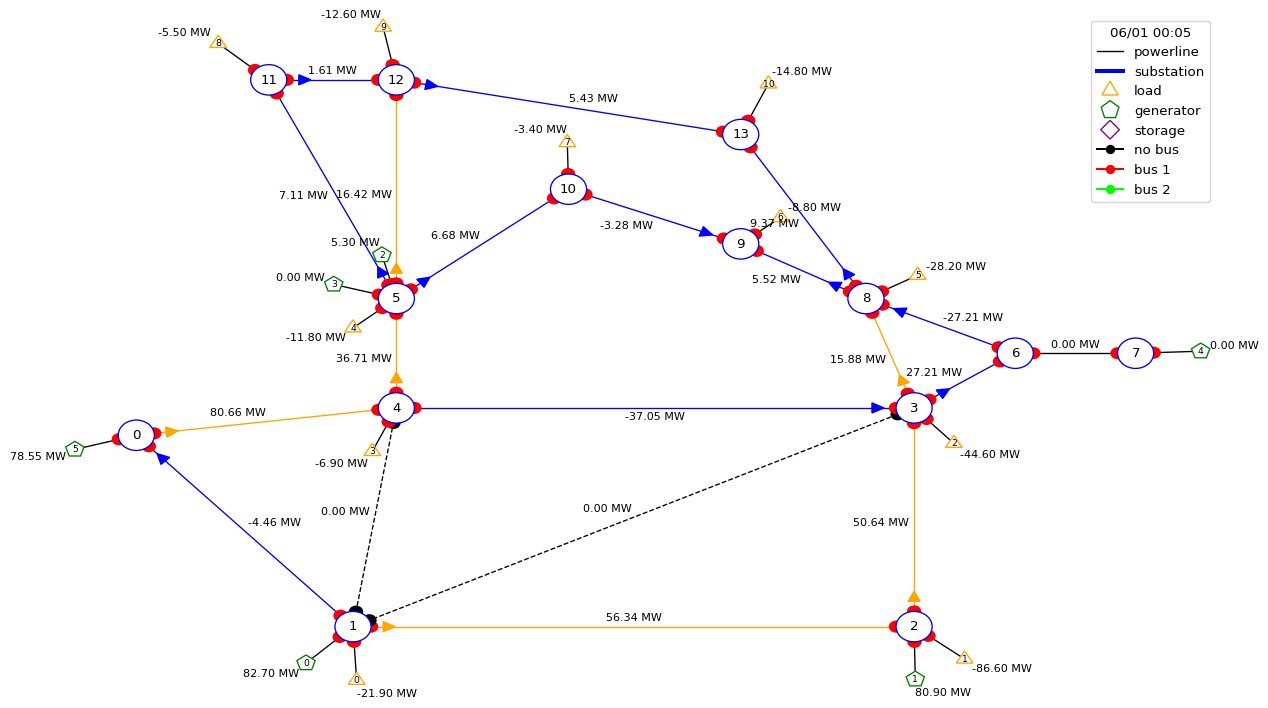

In [26]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs,line_info='p')
fig.show()

In [27]:
np.max(np.abs(por_virtual_N2-obs.p_or))

3.554069483158173e-06

## comparing to real N-K load flow

In [111]:
idls=[3,4,7,14]
#with env.copy() as tmp_env:
obs_NK, *_ = env.simulate(env.action_space({"set_line_status": [(idl, -1) for idl in idls]}))

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



<ipython-input-112-7aa62d7e4dc0>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


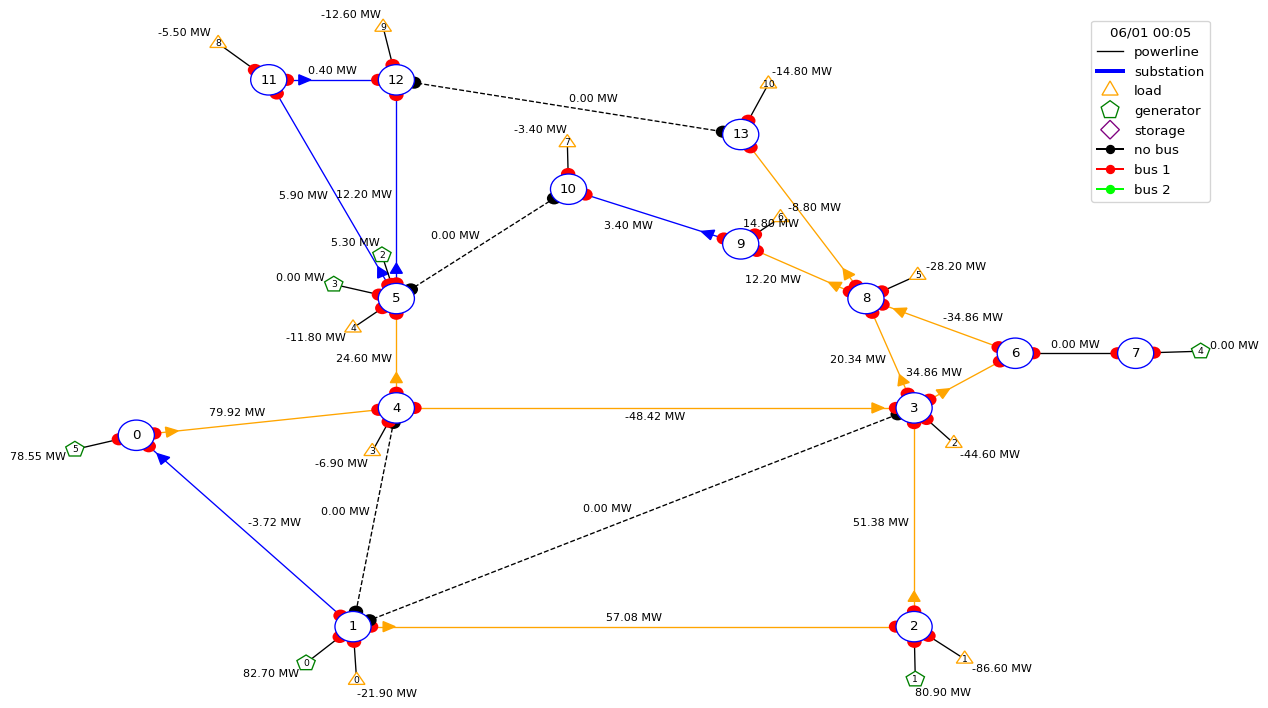

In [112]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_NK,line_info='p')
fig.show()

In [123]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [118]:
por_virtual_NK=get_Virtual_Flows_NK(por_init.copy(),A,idls)
por_virtual_NK

[71.31969722 65.47736318 11.7305305  10.08241989]


array([-3.7246408e+00,  7.9924629e+01,  5.7075367e+01,  8.6634043e-07,
       -2.6242005e-06,  5.1375370e+01, -4.8424644e+01, -4.1106122e-07,
        5.9001088e+00,  1.2199893e+01,  1.2200001e+01,  1.4800000e+01,
        3.4000010e+00,  4.0010759e-01, -4.9511834e-07,  3.4857082e+01,
        2.0342909e+01,  2.4599991e+01,  1.1494497e-14, -3.4857082e+01],
      dtype=float32)

In [117]:
np.max(np.abs(por_virtual_NK-obs_NK.p_or))

1.1444092e-05

## Do topological changes now

In [32]:
from sub_elems import get_valid_sub_action

In [33]:
import json
action_dict_file="unitary_actions_l2rpn_2019.json"
with open(action_dict_file) as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

In [34]:
jsonObject

{'sub_4': {'a': {'lines_id_bus': [[4, 2]], 'loads_id_bus': [[3, 2]]},
  'b': {'lines_id_bus': [[4, 2], [6, 2]]},
  'c': {'lines_id_bus': [[1, 2], [17, 2]]},
  'd': {}},
 'sub_3': {'a': {'lines_id_bus': [[6, 2], [16, 2]]},
  'b': {'lines_id_bus': [[6, 2], [15, 2]]},
  'c': {'lines_id_bus': [[16, 2], [5, 2]]},
  'd': {'lines_id_bus': [[16, 2], [5, 2], [6, 2]]},
  'e': {}},
 'sub_1': {'a': {'lines_id_bus': [[0, 2], [4, 2]], 'loads_id_bus': [[0, 2]]},
  'b': {'lines_id_bus': [[0, 2], [4, 2], [2, 2]]},
  'c': {'lines_id_bus': [[0, 2], [3, 2], [4, 2]]},
  'd': {}},
 'sub_8': {'a': {'lines_id_bus': [[19, 2], [10, 2], [11, 2]]},
  'b': {'lines_id_bus': [[16, 2], [11, 2]]},
  'c': {}},
 'sub_5': {'a': {'lines_id_bus': [[17, 2], [9, 2], [7, 2]]}, 'b': {}}}

### Check correctness by doing N-2 somehow with one N-1 and one topological change

#### Apply first topological change and compute virtual flow from virtual line that will be dispatched by node splitting

In [43]:
sub_id=4
action_1_def={sub_id:{'lines_id_bus': [[4, 2], [6, 2]]}}
#action_1_def={sub_id:{'lines_id_bus': [[4, 2]]}}
action1=get_valid_sub_action(env.action_space,action_1_def)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



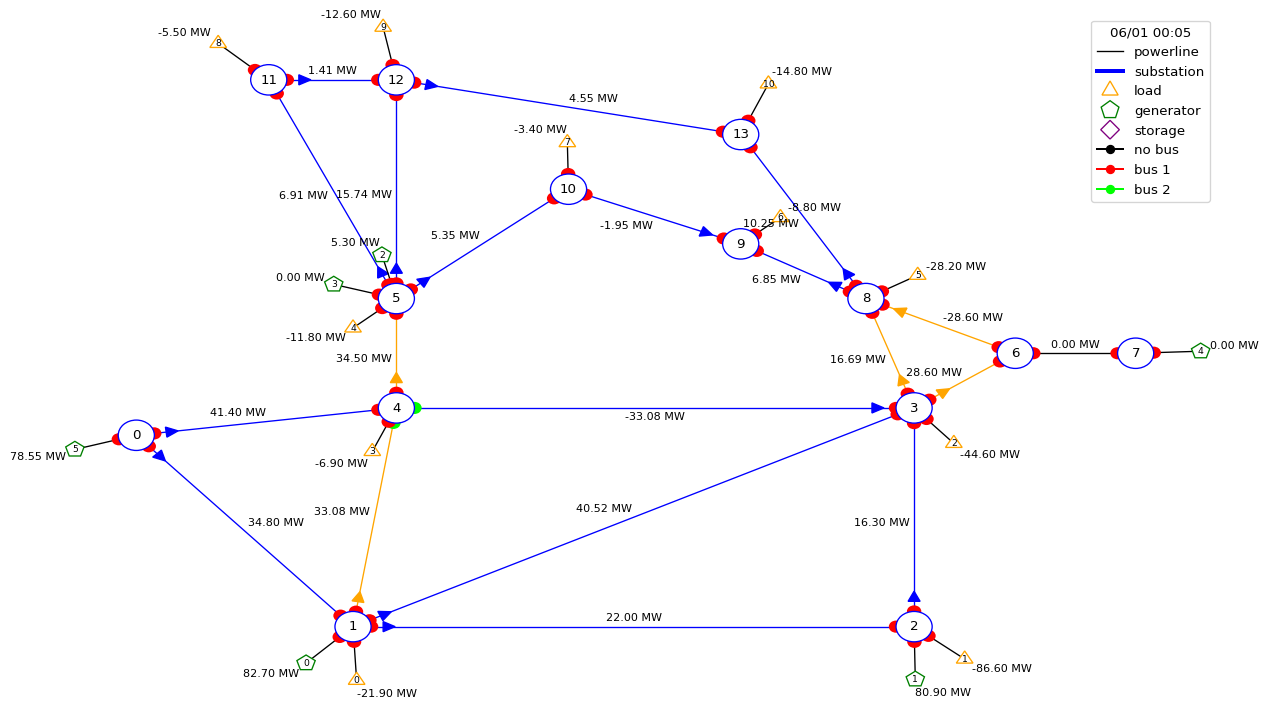

In [133]:
#obs = env.reset()
obs, reward, done, info = env.simulate(env.action_space(action1))
fig_obs = plot_helper.plot_obs(obs, line_info='p')

In [60]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

In [46]:
obs_init, reward, done, info = env.simulate(env.action_space({}))

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



<ipython-input-68-454859aad0a5>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


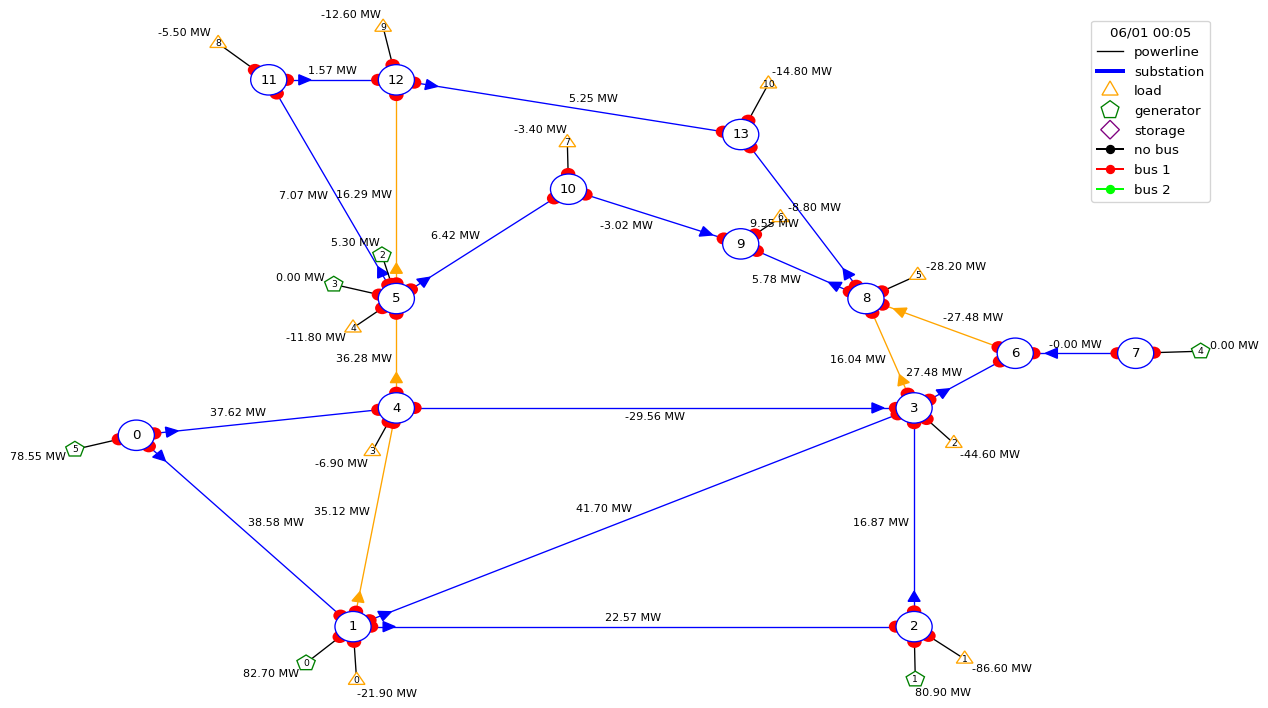

In [68]:
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(obs_init,line_info='p')
fig.show()

In [66]:
delta_flow=obs.p_or-obs_init.p_or
delta_flow

array([-3.7860374e+00,  3.7860374e+00, -5.6282997e-01, -1.1778793e+00,
       -2.0453262e+00, -5.6282997e-01, -3.5135860e+00, -1.0675836e+00,
       -1.5679932e-01, -5.4849148e-01,  1.0675836e+00,  7.0529079e-01,
        1.0675836e+00, -1.5679955e-01, -7.0529127e-01,  1.1195145e+00,
        6.5336037e-01, -1.7728767e+00,  1.1102230e-14, -1.1195145e+00],
      dtype=float32)

In [300]:
a=[]
ilds=[1,17,4,6]
for idl in ilds:
    a_row=[A[idlj][idl] for idlj in ilds]
    a.append(a_row)
a=np.array(a)
b=np.array([delta_flow[idl] for idl in ilds])
print(b)
pls_virt=np.linalg.solve(a,b)
print(pls_virtual)

[ 3.7860374 -1.7728767 -2.0453262 -3.513586 ]
[-11.43387478   5.52957192  -9.98687765 -12.82480569]


In [76]:
delta_flow_recomputed=np.zeros(20)
for i in range(len(ilds)):
    delta_flow_recomputed+= A[ilds[i]]*pls_virtual[i]

In [77]:
delta_flow_recomputed

array([-3.78603574e+00,  3.78603745e+00, -5.62828314e-01, -1.17788041e+00,
       -2.04532623e+00, -5.62828314e-01, -3.51358604e+00, -1.06758407e+00,
       -1.56799726e-01, -5.48492330e-01,  1.06758404e+00,  7.05291424e-01,
        1.06758414e+00, -1.56799619e-01, -7.05291569e-01,  1.11951615e+00,
        6.53360184e-01, -1.77287674e+00,  3.13403260e-15, -1.11951615e+00])

In [ ]:
delta_flow_action=5.56
delta_flow_0_4+delta_flow_4_5=delta_flow_action

In [38]:
#flow_mat, (load, prod, stor, ind_lor, ind_lex) = init_obs.flow_bus_matrix()

In [152]:
#from cvxopt import matrix, solvers
#!pip install --trusted-host pypi.python.org cvxopt

## try pseudo inverse

In [304]:
ilds=[1,17,4,6]
ilds_node1=[1,17]
ilds_node2=[4,6]

In [318]:
#AX=[alpha,-(5.56-alpha),-beta,-5.56+beta]

a_augmented=[]

last_coeff=[[-1,0],[-1,0],[0,1],[0,-1]]
b=[0,-5.56,0,-5.56]#,-5.56]
for i in range(len(ilds)):
    a_row=[A[idlj][ilds[i]] for idlj in ilds]
    a_row+=last_coeff[i]
    #a_row=np.array(a_row)
    a_augmented.append(a_row)
    
#adding constraint that on the virtual line we should have -5.56 
#(42.09-(5.56))/37.62=0.971 for line 1 => np.sum(A[1][ilds_node2])
#(-28.55-(5.56))/36.28=-0.94 for line 17 => np.sum(A[17][ilds_node2])
#(-8.34-(5.56))/35.12=-0.396 for line 4 => np.sum(A[4][ilds_node2])
#(21.21-(5.56))/-29.56=-0.53 for line 6 => -np.sum(A[6][ilds_node2])

#a_row=[np.sum(A[idlj][ilds_node2]) for idlj in ilds]
#a_row+=[0,0]
#a_row=np.array(a_row)
#a_augmented.append(a_row)
a=np.array(a)

pinv=np.linalg.pinv(a_augmented)

In [319]:
#AX=[alpha,-(5.56-alpha),-beta,-5.56+beta]

#a_augmented=[]
#
#last_coeff=[[0],[0],[-1],[-1]]
#b=[3.7860374,-1.7728767,0,-5.56]#,-5.56]
#for i in range(len(ilds)):
#    a_row=[A[idlj][ilds[i]] for idlj in ilds]
#    a_row+=last_coeff[i]
#    #a_row=np.array(a_row)
#    a_augmented.append(a_row)
#    
##adding constraint that on the virtual line we should have -5.56 
##(42.09-(5.56))/37.62=0.971 for line 1 => np.sum(A[1][ilds_node2])
##(-28.55-(5.56))/36.28=-0.94 for line 17 => np.sum(A[17][ilds_node2])
##(-8.34-(5.56))/35.12=-0.396 for line 4 => np.sum(A[4][ilds_node2])
##(21.21-(5.56))/-29.56=-0.53 for line 6 => -np.sum(A[6][ilds_node2])
#
##a_row=[np.sum(A[idlj][ilds_node2]) for idlj in ilds]
##a_row+=[0,0]
##a_row=np.array(a_row)
##a_augmented.append(a_row)
#a=np.array(a)
#
#pinv=np.linalg.pinv(a_augmented)

In [320]:
#array([ 3.7860374, -1.7728767, -2.0453262, -3.513586 ] true values
x = pinv.dot(b)#[-1.98257326  4.19641916 -0.60737363 -0.13390695  1.47436056  0.80934757]
print(x)

[-1.98257326  4.19641916 -0.60737363 -0.13390695  1.47436056  0.80934757]


In [322]:
a.dot(x[0:4])

array([ 1.47436057, -4.08563944, -0.80934758, -4.75065243])

In [334]:
obs_init.p_or[4]+-0.80934758 #obs_init.p_or[4]-beta+obs_init.p_or[6]

34.31241755671875

In [343]:
obs_init.p_or[6]+-4.75065243

-34.31350528949707

In [336]:
obs_init.p_or[1]+1.47436057

39.090769871757814

In [337]:
obs_init.p_or[17]-4.08563944

32.18968252044922

In [353]:
obs_init.p_or[4]+-2.56#-2.0453262

32.56176513671875

In [354]:
obs_init.p_or[6]+-3#-3.513586

-32.56285285949707

In [339]:
obs_init.p_or[1]+3.7860374

41.40244670175781

In [340]:
obs_init.p_or[17]-1.7728767

34.50244526044922

In [323]:
delta_flow_recomputed=np.zeros(20)
for i in range(len(ilds)):
    delta_flow_recomputed+= A[ilds[i]]*x[i]

In [324]:
delta_flow_recomputed

array([-1.47436033e+00,  1.47436057e+00, -2.15020542e-01, -4.49992179e-01,
       -8.09347577e-01, -2.15020542e-01, -4.75065243e+00, -2.46027628e+00,
       -3.61348970e-01, -1.26401406e+00,  2.46027622e+00,  1.62536303e+00,
        2.46027633e+00, -3.61348967e-01, -1.62536305e+00,  2.57995438e+00,
        1.50568496e+00, -4.08563944e+00,  7.49478658e-16, -2.57995438e+00])

In [275]:
#sub_id=4
#sign_sum=[1 if env.line_or_to_subid[idl]==sub_id else -1 for idl in ilds]
#sign_sum

[-1, 1, -1, -1]

### Resistance Matrix

#### R_eq computation

In [381]:
import pandapower as pp
net=env.backend._grid
pp.rundcpp(net)
Bbus_pypower=net._ppc["internal"]["Bbus"].todense().real#["Ybus"]
Bbus_pypower

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



matrix([[ 21.38395703, -16.90045631,   0.        ,   0.        ,
          -4.48350072,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [-16.90045631,  33.37432577,  -5.05127039,  -5.67150635,
          -5.75109271,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  -5.05127039,  10.89819783,  -5.84692744,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  -5.67150635,  -5.84692744,  42.01077444,
         -23.74732843,   0.        ,  -4.88951266,   0.        ,
          -1.85549956,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [ -4.48350072,  -5.75109271,   0.        , -23.74732843,
   

In [384]:
ppc_indices = net._pd2ppc_lookups["bus"][[i for i in range(14)]]
Bbus_pp=Bbus_pypower[ppc_indices,:]#changes rows
Bbus_pp=Bbus_pp[:,ppc_indices]#change colums
Bbus_pp

matrix([[ 21.38395703, -16.90045631,   0.        ,   0.        ,
          -4.48350072,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [-16.90045631,  33.37432577,  -5.05127039,  -5.67150635,
          -5.75109271,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  -5.05127039,  10.89819783,  -5.84692744,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  -5.67150635,  -5.84692744,  42.01077444,
         -23.74732843,   0.        ,  -4.88951266,   0.        ,
          -1.85549956,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [ -4.48350072,  -5.75109271,   0.        , -23.74732843,
   

In [532]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

In [529]:
env.name_line
env.backend._grid.line["x_ohm_per_km"]

0     11.268335
1     42.475738
2     37.701407
3     33.578381
4     33.113707
5     32.570953
6      8.019428
7      0.795600
8      1.023240
9      0.521080
10     0.338000
11     1.081520
12     0.768280
13     0.799520
14     1.392080
Name: x_ohm_per_km, dtype: float64

In [530]:
1/11.268335

0.08874425547341289

In [534]:
-Bbus_pp[0,1]

16.900456312320433

In [385]:
pinv_Bbus=np.linalg.pinv(Bbus_pp)

In [390]:
#Rij=L†ii + L†jj − 2L†ij 
pinv_Bbus=np.linalg.pinv(Bbus_pp)
n_nodes=pinv_Bbus.shape[0]
R_eq=[[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)]

#### R_eq manipulation and update

In [442]:
def get_paralell_R(R_eq_i_j,w_ij,i,j):
    #w_ij=1/-Bbus[i,j]
    R_paralell=R_eq_i_j*w_ij/(w_ij-R_eq_i_j)
    return R_paralell

In [493]:
#deleting edje (i,j) Ωxy + ((Ωxj −Ωxi) − (Ωjy −Ωiy))^2/ 4(ωij−Ωij )
def Req_Update_edge_delete(R_eq,Bbus,x,y,i,j):
    #x,y edge of interest
    #i,j edge deleted
    w_ij=1/-Bbus[i,j]
    Req_update=(R_eq[x][y])+((R_eq[x][j]-R_eq[x][i])-(R_eq[j][y]-R_eq[i][y]))**2/(4*(w_ij-R_eq[i][j]))
    return Req_update

#### R_eq checking

For line 6-7, the Req is obvious as there is a single path

In [516]:
print(R_eq[6][7])
1/Bbus_pp[6,7]

0.17614999999999975


-0.17614999999999997

In [519]:
print(np.array(R_eq[6])-np.array(R_eq[7]))

[-0.17615 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615  0.17615
 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615 -0.17615]


For line 0-4, if deleting line 0-1, the Req is obvious as there is a single path (and conversely)

In [524]:
x=0
y=4

i=0
j=1

print(Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j))
-1/Bbus_pp[x,y]

0.22304000000000174


0.22304000000000002

In [525]:
x=0
y=1

i=0
j=4

print(Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j))
-1/Bbus_pp[x,y]

0.05917000000000013


0.05917

if deleting line 4-5, the Req is the sum of Req_3 + Req_3-8+Req_8

In [527]:
x=0
y=10

i=4
j=5


print(Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j))
print(Req_Update_edge_delete(R_eq,Bbus_pp,x,3,i,j))
print(Req_Update_edge_delete(R_eq,Bbus_pp,3,8,i,j))
print(Req_Update_edge_delete(R_eq,Bbus_pp,8,y,i,j))

0.5071725208773611
0.09598660504551795
0.19861553100693655
0.21257038482490692


In [528]:
Req_Update_edge_delete(R_eq,Bbus_pp,x,3,i,j)+Req_Update_edge_delete(R_eq,Bbus_pp,3,8,i,j)+Req_Update_edge_delete(R_eq,Bbus_pp,8,y,i,j)

0.5071725208773614

In [509]:
#check Req computation by load flow
flow_mat, (load, prod, stor, ind_lor, ind_lex) = init_obs.flow_bus_matrix()
injections=np.diag(flow_mat)


In [510]:
np.array(R_eq).dot(injections)

array([-25.40571743, -20.72320889, -11.55377285,  -5.91197198,
        -8.42168021,   8.98008126,   5.62595634,   6.03990908,
        11.69395299,  12.77714154,  11.69443866,  12.89213609,
        13.37382443,  17.16381301])

In [513]:
print(R_eq[0][1])
1/Bbus_pp[0,1]

0.049585563497863416


-0.05917

In [514]:
print(R_eq[0][4])
1/Bbus_pp[0,4]

0.08685509921183387


-0.22304000000000002

In [520]:
1/Bbus_pp[1,4]

-0.17388

In [404]:
#array([ 3.7860374, -1.7728767, -2.0453262, -3.513586 ]
print(R_eq[4][5])
print(R_eq[0][4])

#1.77/3.78
#0.08685509921183387/0.16184222873853787

0.16184222873853787
0.08685509921183387


#### R_eq manual nodal computation for topological change

In [ ]:
#for node 2(line 1-4 and 3-4) to node 1
# to go to node 1 by line 0-4
# R11 line 3-4 => sub 1 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                         =>  R13 line 1-0 => line 0-4
# R12 line 4-1 => sub1

# R21 line 4-1 => sub3 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                        => R23 sub5 (through distribution grid) => line 4-5
# R22 line 3-4 => sub3 

In [539]:
w01=-1/Bbus_pp[0,1]
w04=-1/Bbus_pp[0,4]
w14=-1/Bbus_pp[1,4]
w34=-1/Bbus_pp[3,4]
w32=-1/Bbus_pp[3,2]
w12=-1/Bbus_pp[1,2]
w31=-1/Bbus_pp[1,3]
w45=-1/Bbus_pp[4,5]
w123=w12+w32

In [536]:
R12=w14
R22=w34
R123=w123*w31/(w31+w123)

In [540]:
R11=w34+R123
R13=w01+w04
R1=R11*R12/(R12+R11)+R13
R1

0.3659192199957916

In [541]:
R21=w14+R123
R23=Req_Update_edge_delete(R_eq,Bbus_pp,3,5,4,5)+w45
R2=R21*R22/(R22+R21)+R23
R2

0.7566365156633286

In [544]:
0.3659/0.7566

0.4836108908273856

In [543]:
R_node1_node2=R1*R2/(R1+R2)
R_node1_node2

0.2466406208946881

In [ ]:
#for node 1(line 0-4 and 4-5) to node 2
# to go to node 2 by line &-4
# R11 line 4-5 => R13 sub3 (through distribution grid) => R123 sub 1 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                                                                      => line 1-4
# R12 line 4-0 => line 0-1 

# R21 line 4-0 => line 0-1 => R23 sub 1 (thorugh line 3-1 and line 3-2 => 2-1)
#                                                                             => line 3-4
# R22 line 4-5 => R24 sub3 (through distribution grid)

In [545]:
R13=Req_Update_edge_delete(R_eq,Bbus_pp,3,5,4,5)
R123=w123*w31/(w31+w123)
R11=w45+R13+R123
R12=w01+w04

R1=R11*R12/(R11+R12)+w14
R1

0.38506529688181934

In [546]:
R21=R12+R123
R22=w45+R13
R2=R21*R22/(R21+R22)+w34
R2

0.299856424848389

#### R_eq manual nodal systematic for topological change

In [487]:
i=4
j=5

x=0
y=4

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_04_delete_45=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_04_delete_45)

R_eq_node1_node2_sub0=get_paralell_R(R_eq_04_delete_45,w_xy,x,y)+w_xy
print(R_eq_node1_node2_sub0)


0.22304000000000002
0.23488264000000003
0.08685509921183387
0.08708966210692048
0.36591921999579186


In [488]:
i=0
j=4

x=4
y=5

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_45_delete_04=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_45_delete_04)

R_eq_node1_node2_sub5=get_paralell_R(R_eq_45_delete_04,w_xy,x,y)+w_xy
print(R_eq_node1_node2_sub5)


0.23488264000000003
0.22304000000000002
0.16184222873853787
0.161968032482012
0.7566365156633287


In [447]:
#0.3653001868919218/0.7553735954179829
#=> 0.483
#vs 1.77/3.78
#=> 0.468

0.4836020071495674

In [498]:
i=1
j=4

x=4
y=3

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_34_delete_14=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_34_delete_14)

R_parallel=get_paralell_R(R_eq_34_delete_14,w_xy,x,y)
print(R_parallel)
R_eq_node1_node2_sub3=R_parallel+w_xy
print(R_eq_node1_node2_sub3)


0.04211
0.17388
0.033848042692293995
0.036196329479528166
0.2577464248483896
0.2998564248483896


In [499]:
#env.name_line
#env.backend._grid.line["x_ohm_per_km"]

In [500]:
x=4
y=1

i=3
j=4

w_xy=1/-Bbus_pp[x,y]
print(w_xy)
w_ij=1/-Bbus_pp[i,j]
print(w_ij)
R_eq_xy=R_eq[x][y]
print(R_eq_xy)

R_eq_14_delete_34=Req_Update_edge_delete(R_eq,Bbus_pp,x,y,i,j)
print(R_eq_14_delete_34)

R_parallel=get_paralell_R(R_eq_14_delete_34,w_xy,x,y)
print(R_parallel)
R_eq_node1_node2_sub1=R_parallel+w_xy
print(R_eq_node1_node2_sub1)


0.17388
0.04211
0.06418402193104036
0.09536278579027792
0.21118529688181886
0.3850652968818189


In [452]:
#0.2998/0.38506
#=>0.778
#2.04/3.51
#=>0.581

0.5811965811965812

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-86-1d7851251705>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


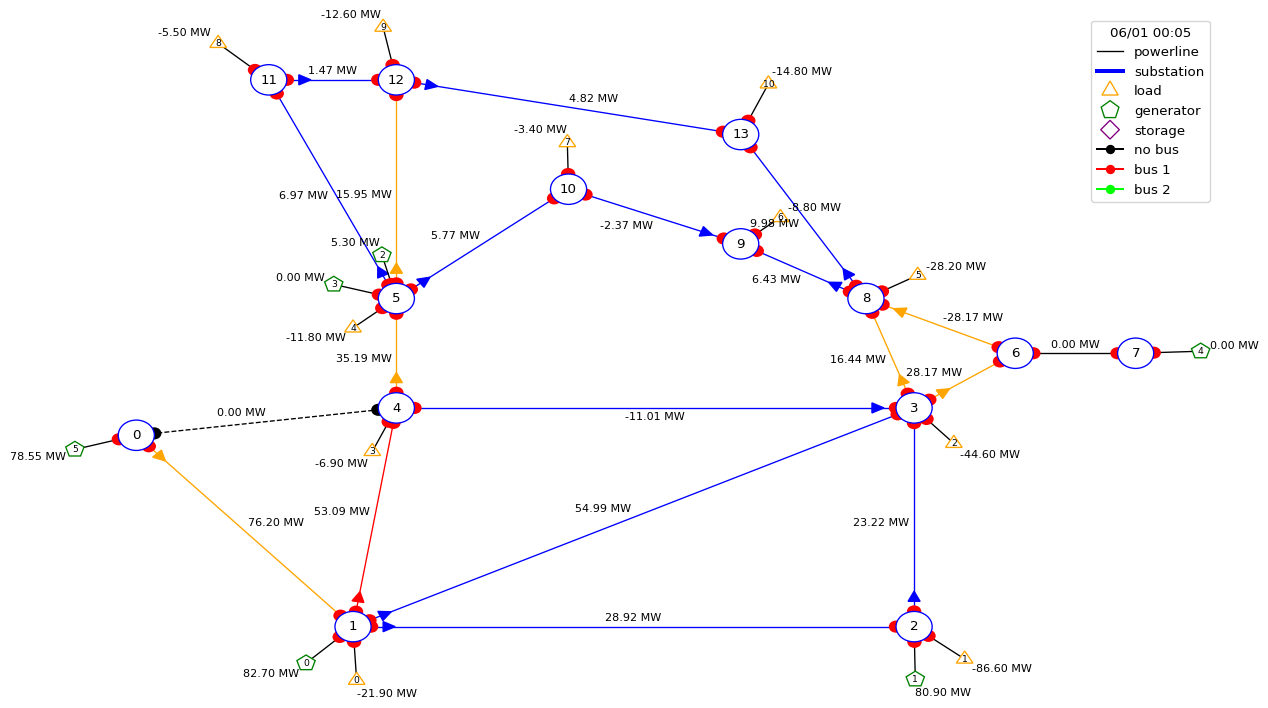

In [86]:
obs_l1, *_ = env.simulate(env.action_space({"set_line_status": [(1, -1)]}))
fig = plot_helper.plot_obs(obs_l1,line_info='p')
fig.show()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-87-266dfcbc7f9c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


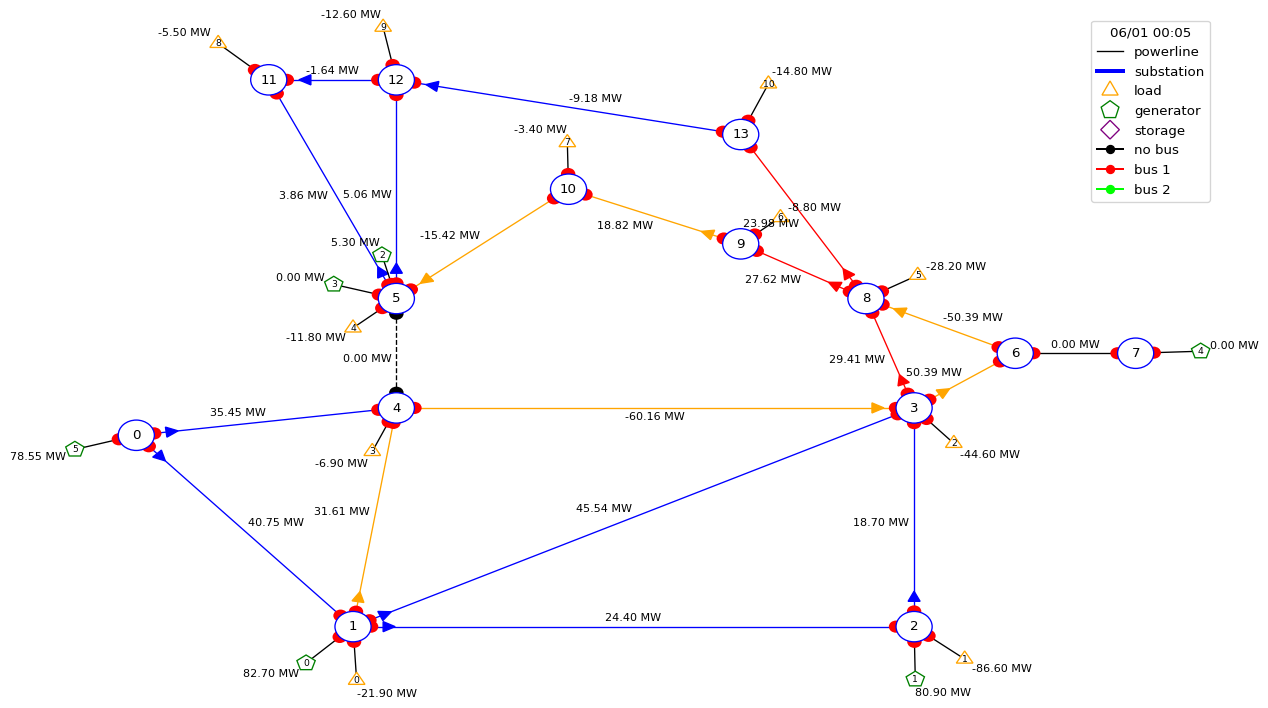

In [87]:
obs_l17, *_ = env.simulate(env.action_space({"set_line_status": [(17, -1)]}))
fig = plot_helper.plot_obs(obs_l17,line_info='p')
fig.show()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-243-1beff1836e98>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


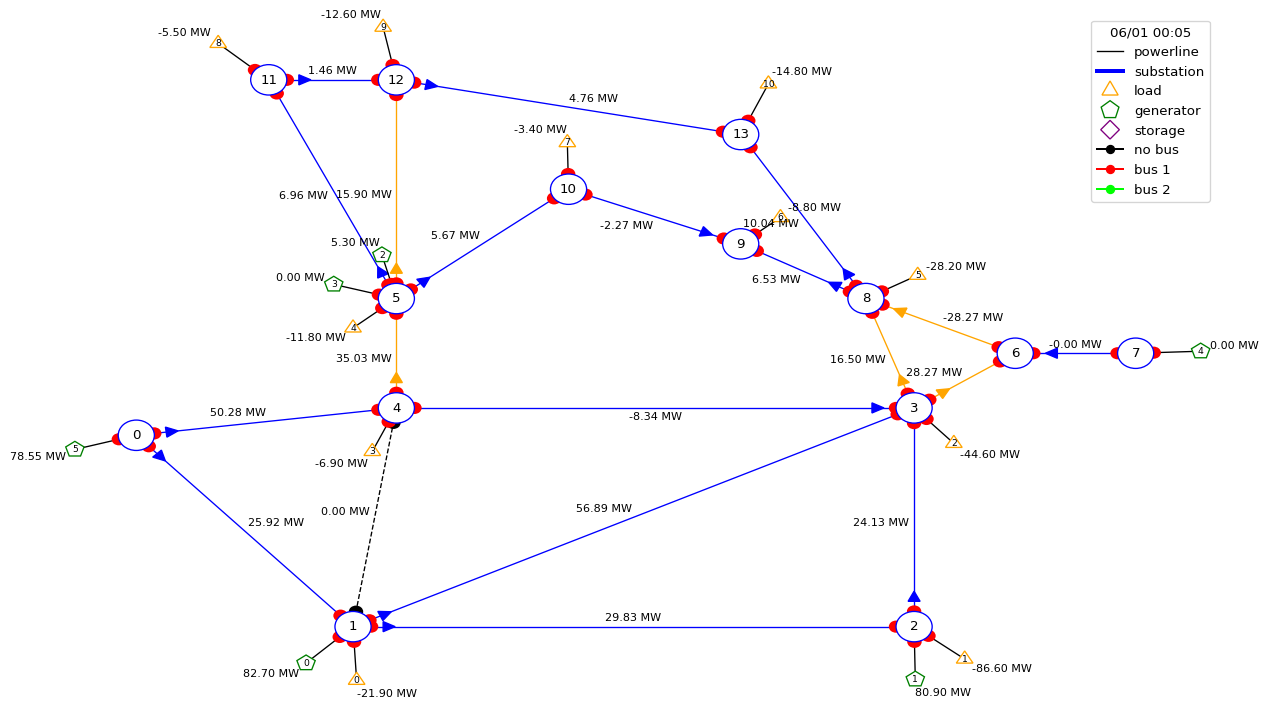

In [243]:
obs_l17, *_ = env.simulate(env.action_space({"set_line_status": [(4, -1)]}))
fig = plot_helper.plot_obs(obs_l17,line_info='p')
fig.show()

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

<ipython-input-244-040d12f18a06>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


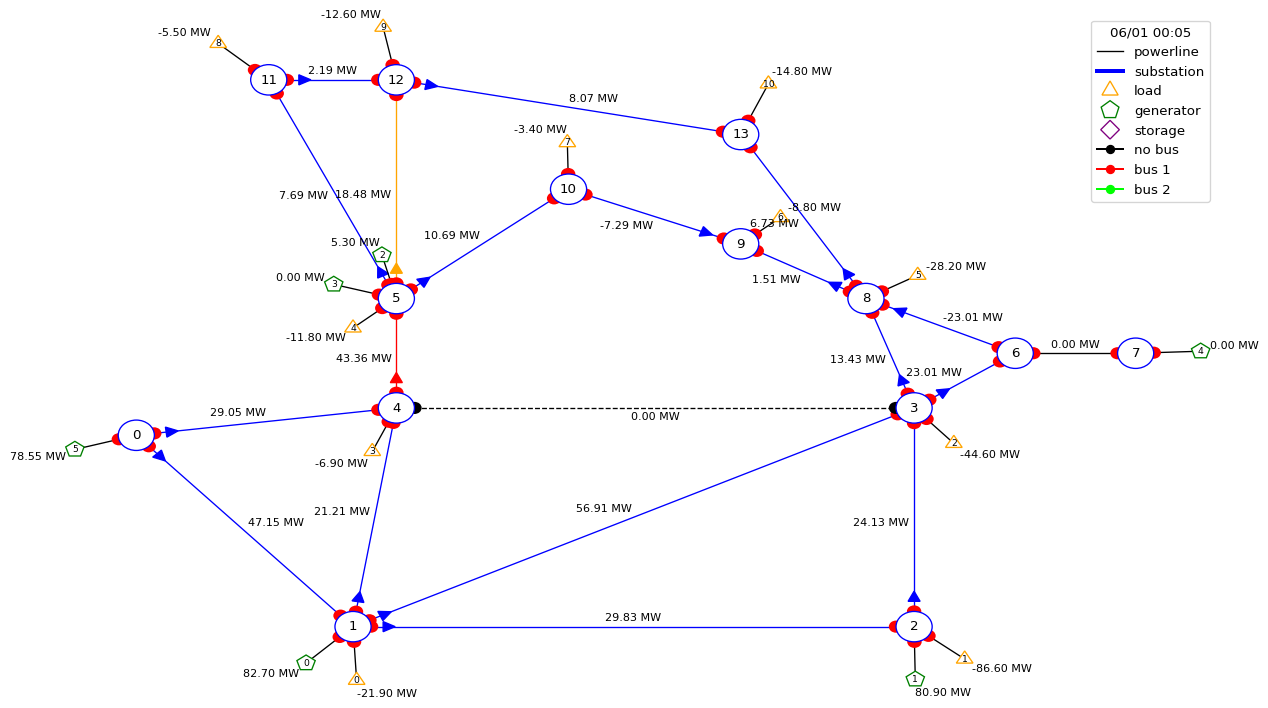

In [244]:
obs_l6, *_ = env.simulate(env.action_space({"set_line_status": [(6, -1)]}))
fig = plot_helper.plot_obs(obs_l6,line_info='p')
fig.show()

In [61]:
InjectionsNode1=[-por_init[i] for i in range(env.n_line) if ind_lor[i]==sub_id]
InjectionsNode1+=[por_init[i] for i in range(env.n_line) if ind_lex[i]==sub_id]
InjectionsNode1+=[-init_obs.load_p[i] for i in range(len(load)) if load[i]==sub_id]
InjectionsNode1+=[init_obs.gen_p[i] for i in range(len(prod)) if prod[i]==sub_id]
InjectionsNode1

[-36.275322, 37.61641, -6.9]

In [64]:
np.sum(InjectionsNode1)

-5.5589128

In [41]:
#sub_id_2=14
#InjectionsNode2=[-por_init[i] for i in range(env.n_line) if ind_lor[i]==sub_id_2]
#InjectionsNode2+=[por_init[i] for i in range(env.n_line) if ind_lex[i]==sub_id_2]
#InjectionsNode2+=[-init_obs.load_p[i] for i in range(len(load)) if load[i]==sub_id_2]
#InjectionsNode2+=[init_obs.gen_p[i] for i in range(len(prod)) if prod[i]==sub_id_2]
#InjectionsNode2

In [42]:
virtualFlow=-np.sum(InjectionsNode1)

In [258]:
F_topo = virtualFlow
A_topo=(obs.p_or-por_init)/F_topo#.reshape(-1, 1)
#delta_flow_topo=np.abs(obs.p_or-por_init)/

In [259]:
A_topo

array([-3.6050677e-01,  3.6050671e-01,  2.0676929e-01,  4.3272394e-01,
       -1.0000000e+00,  2.0676929e-01,  6.0414976e-01, -2.1283003e-02,
       -3.1258960e-03, -1.0934554e-02,  2.1283003e-02,  1.4060450e-02,
        2.1283003e-02, -3.1259062e-03, -1.4060450e-02,  2.2318279e-02,
        1.3025146e-02, -3.5343479e-02,  3.1610685e-16, -2.2318279e-02],
      dtype=float32)

In [260]:
#por_init+virtualFlow*A_topo

#### Compute combined N-1 + topological change

In [266]:
def get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id):
    A_idl1_virtual_line=[A[idl1][i] for i in range(env.n_line) if ind_lor[i]==sub_id]
    A_idl1_virtual_line+=[-A[idl1][i] for i in range(env.n_line) if ind_lex[i]==sub_id]
    print(A_idl1_virtual_line)
    A_idl1_virtual_line=np.sum(A_idl1_virtual_line)
    print(A_idl1_virtual_line)
    
    return A_idl1_virtual_line

def get_Virtual_Flows_N1_topo(por_init,por_topo,A,idl1,A_topo,ind_lor,ind_lex,sub_id ):
    A_idl1_virtual_line=get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id)
   
    a=np.array([[A[idl1][idl1],A[idl2][idl1]],[A[idl1][idl2],A[idl2][idl2]]])
    
    a=np.array([[-1,A_topo[idl1]],[A_idl1_virtual_line,-1]])
    b=np.array([-por_init[idl1],-por_topo])
    #print(a)
    #print(b)
    [pl1_virtual,pl2_virtual]=np.linalg.solve(a,b)
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A_topo*pl2_virtual
    
    return por_virtual

In [267]:
virtualFlow

35.121765

In [269]:
line_action={"set_line_status": [(idl1, -1)]}
act=env.action_space(line_action)
act+=env.action_space(action1)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



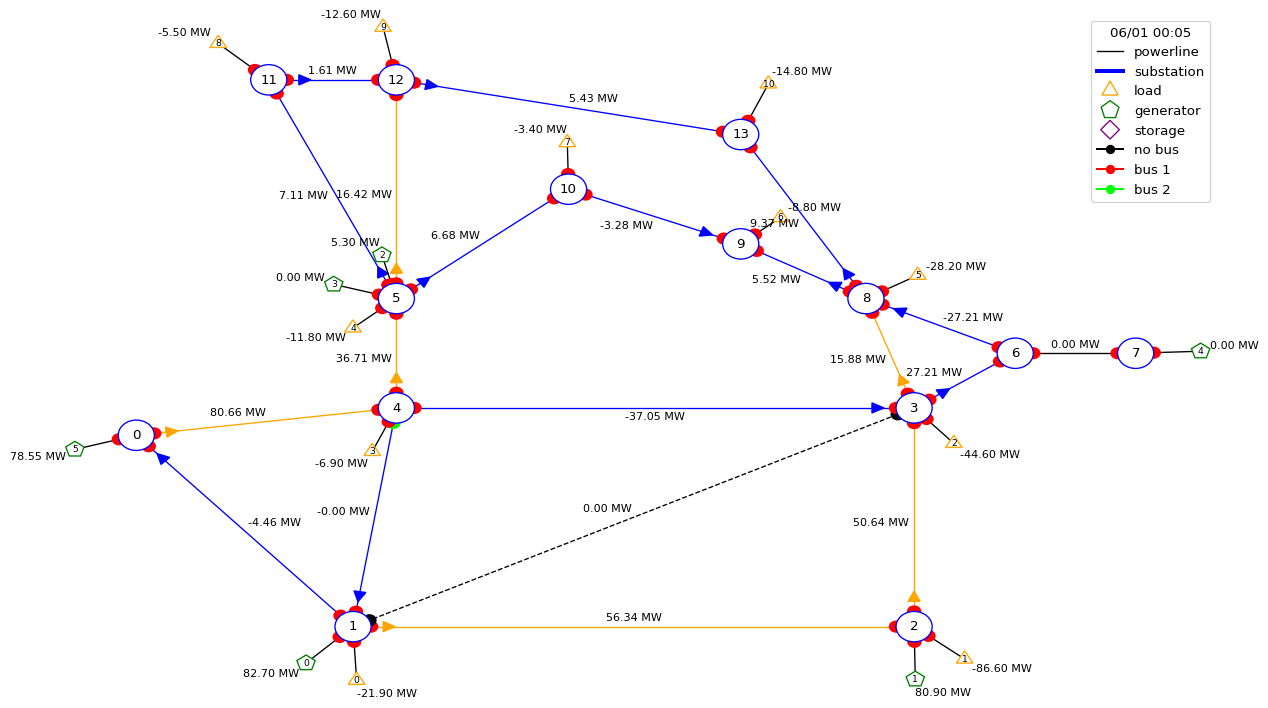

In [270]:
obs_topo_N1, reward, done, info = env.simulate(act)
fig_obs = plot_helper.plot_obs(obs_topo_N1, line_info='p')

In [271]:
idl1=3
por_virtual_topo_N1=get_Virtual_Flows_N1_topo(por_init,virtualFlow,A,idl1,A_topo,ind_lor,ind_lex,sub_id)

[0.03949445921162586, -0.2724346441674472, 0.675105901946444]
0.4421657169906227
70.35573603945282
66.2306596070064


In [272]:
np.max(np.abs(por_virtual_topo_N1-obs_topo_N1.p_or))

3.340496277988436e-06

In [240]:
#can be compared to previous N-2 computation in that case
idl1=3
idl2=4
por_virtual_N2=get_Virtual_Flows_N2(por_init,A,idl1,idl2)

[[-1.          0.43272394]
 [ 0.44216576 -1.        ]]
[-41.696144 -35.121765]
70.35573775031565
66.23066358184452


In [217]:
np.max(np.abs(por_virtual_N2-obs_topo_N1.p_or))

3.554069483158173e-06

### Now try one real bus splitting topological change + N-1

#### Apply first topological change and compute virtual flow from virtual line that will be dispatched by node splitting

In [273]:
sub_id=4
action_1_def={sub_id:{'lines_id_bus': [[4, 2], [6, 2]]}}
#action_1_def={sub_id:{'lines_id_bus': [[4, 2]]}}
action1=get_valid_sub_action(env.action_space,action_1_def)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



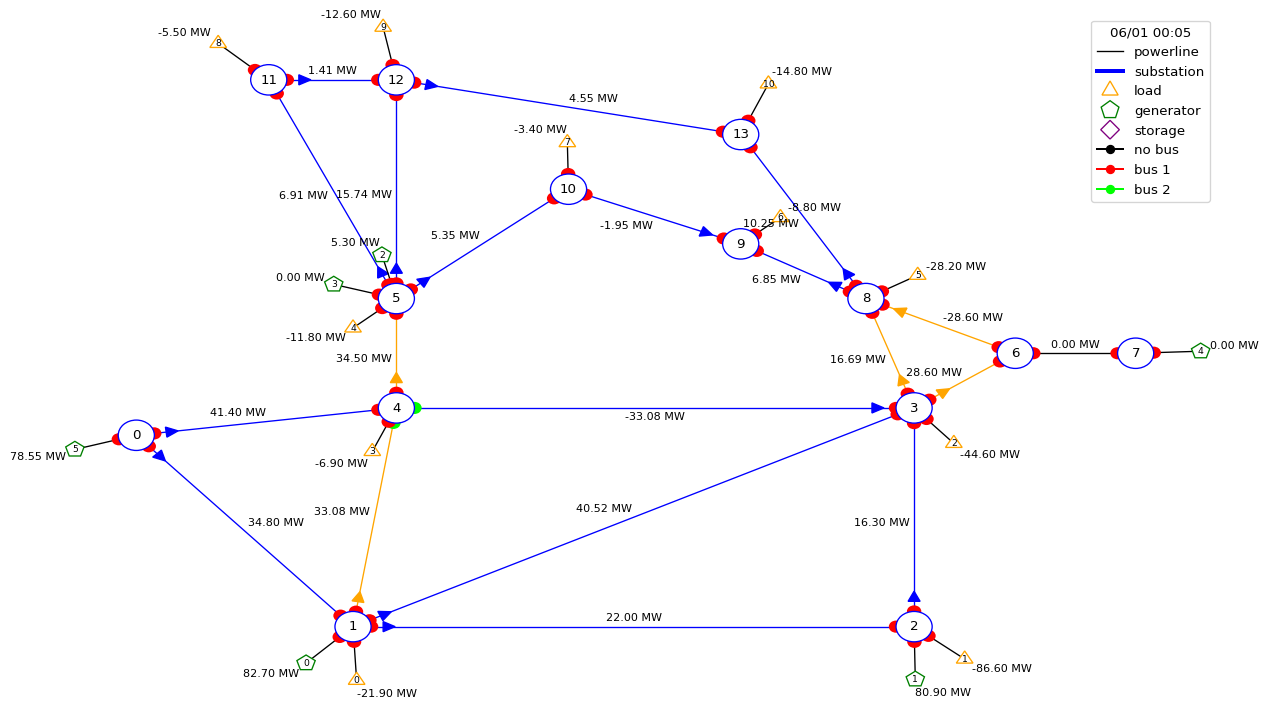

In [274]:
#obs = env.reset()
obs, reward, done, info = env.simulate(env.action_space(action1))
fig_obs = plot_helper.plot_obs(obs, line_info='p')

In [281]:
flow_mat, (load, prod, stor, ind_lor, ind_lex) = obs.flow_bus_matrix()

In [282]:
InjectionsNode1=[-por_init[i] for i in range(env.n_line) if ind_lor[i]==sub_id]
InjectionsNode1+=[por_init[i] for i in range(env.n_line) if ind_lex[i]==sub_id]
InjectionsNode1+=[-init_obs.load_p[i] for i in range(len(load)) if load[i]==sub_id]
InjectionsNode1+=[init_obs.gen_p[i] for i in range(len(prod)) if prod[i]==sub_id]
InjectionsNode1

[-36.275322, 37.61641, -6.9]

In [283]:
np.sum(InjectionsNode1)

-5.5589128

In [284]:
virtualFlow=-np.sum(InjectionsNode1)

In [285]:
F_topo = virtualFlow
A_topo=(obs.p_or-por_init)/F_topo#.reshape(-1, 1)
#delta_flow_topo=np.abs(obs.p_or-por_init)/

In [286]:
A_topo

array([-6.8107516e-01,  6.8107516e-01, -1.0124821e-01, -2.1189024e-01,
       -3.6793637e-01, -1.0124821e-01, -6.3206351e-01, -1.9204898e-01,
       -2.8206831e-02, -9.8668844e-02,  1.9204898e-01,  1.2687567e-01,
        1.9204898e-01, -2.8206874e-02, -1.2687576e-01,  2.0139091e-01,
        1.1753384e-01, -3.1892508e-01,  1.9971946e-15, -2.0139091e-01],
      dtype=float32)

In [287]:
#por_init+virtualFlow*A_topo

#### Compute combined N-1 + topological change

In [288]:
def get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id):
    A_idl1_virtual_line=[A[idl1][i] for i in range(env.n_line) if ind_lor[i]==sub_id]
    A_idl1_virtual_line+=[-A[idl1][i] for i in range(env.n_line) if ind_lex[i]==sub_id]
    print(A_idl1_virtual_line)
    A_idl1_virtual_line=np.sum(A_idl1_virtual_line)
    print(A_idl1_virtual_line)
    
    return A_idl1_virtual_line

def get_Virtual_Flows_N1_topo(por_init,por_topo,A,idl1,A_topo,ind_lor,ind_lex,sub_id ):
    A_idl1_virtual_line=get_A_idl1_virtual_line(A,ind_lor,ind_lex,sub_id)
   
    a=np.array([[A[idl1][idl1],A[idl2][idl1]],[A[idl1][idl2],A[idl2][idl2]]])
    
    a=np.array([[-1,A_topo[idl1]],[A_idl1_virtual_line,-1]])
    b=np.array([-por_init[idl1],-por_topo])
    #print(a)
    #print(b)
    [pl1_virtual,pl2_virtual]=np.linalg.solve(a,b)
    print(pl1_virtual)
    print(pl2_virtual)
    
    por_virtual=por_init+A[idl1]*pl1_virtual+A_topo*pl2_virtual
    
    return por_virtual

In [289]:
virtualFlow

5.5589128

In [290]:
line_action={"set_line_status": [(idl1, -1)]}
act=env.action_space(line_action)
act+=env.action_space(action1)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



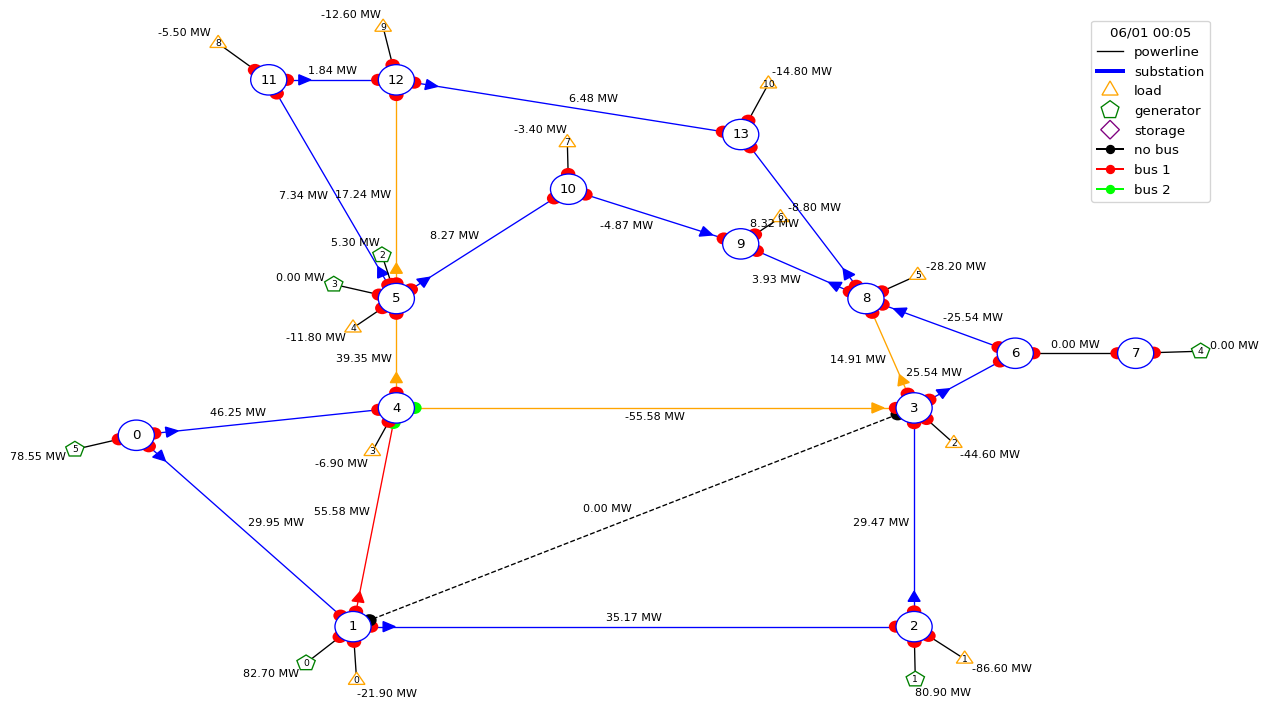

In [291]:
obs_topo_N1, reward, done, info = env.simulate(act)
fig_obs = plot_helper.plot_obs(obs_topo_N1, line_info='p')

In [292]:
idl1=3
por_virtual_topo_N1=get_Virtual_Flows_N1_topo(por_init,virtualFlow,A,idl1,A_topo,ind_lor,ind_lex,sub_id)

[0.03949445921162586, -0.2724346441674472]
-0.23294018495582136
42.62199034307362
-4.369461559641963


In [293]:
np.max(np.abs(por_virtual_topo_N1-obs_topo_N1.p_or))

2.708169205334343e-06